In [1]:
import pandas as pd
import numpy as np
import json

from utils.feature_engineering import *
from utils.data_cleaning import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.metrics import accuracy_score, classification_report, f1_score


from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time 
import warnings 


warnings.filterwarnings('ignore')

2025-05-22 16:13:34.152730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 16:13:34.200579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

In [125]:
import pandas as pd 
pd.set_option('display.max_columns', None)  
df = pd.read_excel('../Dataset_2.0_Akkodis.xlsx')
df

,ID,Candidate State,Age Range,Residence,Sex,Protected category,TAG,Study area,Study Title,Years Experience,Sector,Last Role,Year of insertion,Year of Recruitment,Recruitment Request,Assumption Headquarters,Job Family Hiring,Job Title Hiring,event_type__val,event_feedback,linked_search__key,Overall,Job Description,Candidate Profile,Years Experience.1,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis headquarters,Current Ral,Expected Ral,Technical Skills,Standing/Position,Comunication,Maturity,Dynamism,Mobility,English
0,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Candidate notification,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,NaN,RS18.0145,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Contact note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,BM interview,OK,RS18.0114,~ 2 - Medium,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,2.0,2.0,1.0,2.0,2.0,3.0,3.0
4,71470,Hired,31 - 35 years,TURIN » Turin ~ Piedmont,Male,NaN,"AUTOSAR, CAN, C, C++, MATLAB/SIMULINK, VECTOR/...",Automation/Mechatronics Engineering,Five-year degree,[1-3],Automotive,Diagnostic/Test engineer,[2018],[2021],E/E Diagnostic Integration Engineer - Automotive,Milan,Engineering,Consultant,Commercial note,NaN,NaN,NaN,"The candidate, inserted within a multidiscipli...",The ideal candidate has a degree in Electronic...,[1-3],26-28K,30-32K,Five-year degree,electronic Engineering,Modena,22-24 K,24-26 K,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21372,79993,Hired,26 - 30 years,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemical engineering,Five-year degree,[0],Others,Graduating student,[2023],[2023],Junior Project Engineer (C&Q),Pomezia,Tech Consulting & Solutions,Consultant,HR interview,OK,RS23.0793,~ 3 - High,"The resource, included in a team dedicated to ...",The ideal candidate has a Master's Degree in C...,[0],- 20K,- 20K,Five-year degree,chemical engineering,Pomezia,Not available,Not available,2.0,2.0,3.0,3.0,3.0,3.0,3.0
21373,79993,Hired,26 - 30 years,TORRE ANNUNZIATA » Naples ~ Campania,Male,NaN,X,chemic

## Remove rows

### Drop duplicates

In [126]:
df = df.drop_duplicates().reset_index(drop=True)

### Clean the columns' names

In [127]:
df = clean_dataframe_columns(df)

### Create new IDs and separate different people with duplicating IDs

In [128]:
invariant_columns = [
    "ID",
    "Sex",
    "Job Title Hiring",
    "Study Area.1",
    "Assumption Headquarters",
    "Year of insertion",
    "Age Range",
    "Study area",
    "Study Title",
    "Years Experience",
    "Residence",
]
df = split_duplicate_ids_by_invariant_columns(df, invariant_columns)

🔵 Unique IDs before cleaning: 12263
🟢 Unique IDs after cleaning: 13372
🧮 Difference: 1109 new IDs created


### Extract `numer_of_searches` column

In [129]:
df['number_of_searches'] = pd.to_numeric(
    df['linked_search__key'].str.split('.', n=1, expand=True)[1], 
    errors='coerce'
)

### Remove irrelevant columns

In [130]:
df = df.drop(columns=['linked_search__key', 'Year of Recruitment']) 

### Remove candidates in first stages

In [131]:
df = remove_initial_stage_candidates(df)

🗂️ Removed 7440 initial-stage only candidates.


### Removal of Candidates with Inconsistent Final Outcomes

In [132]:
state_order = ['imported', 'first contact', 'in selection', 'qm', 'economic proposal', 'vivier', 'hired']
event_order = ['cv request', 'contact note', 'hr interview', 'bm interview', 'technical interview', 
               'qualification meeting', 'economic proposal', 'candidate notification']

grouped = df.groupby('ID', group_keys=False).apply(sort_group, state_order=state_order, event_order=event_order)

df = grouped.reset_index(drop=True)

In [133]:
feedbacks_to_remove = [
        'OK (other candidate)', 
        'KO (lost availability)', 
        'OK (hired)', 
        'OK (waiting for departure)', 
        'KO (opportunity closed)', 
        'KO (retired)', 
        'KO (ral)', 
        'KO (proposed renunciation)'
    ]


df = remove_not_hired_valid_candidates(df, state_order=state_order, event_order=event_order, feedbacks_to_remove=feedbacks_to_remove)

Number of unique IDs to remove: 1040
Total IDs before cleaning: 5932
Total IDs after cleaning: 4892
Total IDs removed: 1040


In [134]:
states_to_drop = ['vivier', 'economic proposal']

print("Before filtering:")
for c in list(set(df['Candidate State'])):
    print(f"{c}: {len(df[df['Candidate State']==c])} rows")
total_ids_before = df['ID'].nunique()

df = df[~df['Candidate State'].isin(states_to_drop)]

print("\nAfter filtering:")
for c in list(set(df['Candidate State'])):
    print(f"{c}: {len(df[df['Candidate State']==c])} rows")

total_ids_after = df['ID'].nunique()
print(f"Total IDs before cleaning: {total_ids_before}")
print(f"Total IDs after cleaning: {total_ids_after}")
print(f"Total IDs removed: {total_ids_before - total_ids_after}")

Before filtering:
qm: 399 rows
vivier: 28 rows
in selection: 3044 rows
imported: 311 rows
hired: 2143 rows
economic proposal: 46 rows
first contact: 3093 rows

After filtering:
qm: 399 rows
in selection: 3044 rows
imported: 311 rows
hired: 2143 rows
first contact: 3093 rows
Total IDs before cleaning: 4892
Total IDs after cleaning: 4870
Total IDs removed: 22


## Preprocess columns

### Ral Mapping

In [135]:
ral_mapping = {
    '- 20 K': 19000,
    '- 20K': 19000,
    '20-22 K': 21000,
    '20-22K': 21000,
    '22-24 K': 23000,
    '22-24K': 23000,
    '24-26 K': 25000,
    '24-26K': 25000,
    '26-28 K': 27000,
    '26-28K': 27000,
    '28-30 K': 29000,
    '28-30K': 29000,
    '30-32 K': 31000,
    '30-32K': 31000,
    '32-34 K': 33000,
    '32-34K': 33000,
    '34-36 K': 35000,
    '34-36K': 35000,
    '36-38 K': 37000,
    '36-38K': 37000,
    '38-40 K': 39000,
    '38-40K': 39000,
    '40-42 K': 41000,
    '40-42K': 41000,
    '42-44 K': 43000,
    '42-44K': 43000,
    '44-46 K': 45000,
    '44-46K': 45000,
    '46-48 K': 47000,
    '46-48K': 47000,
    '48-50 K': 49000,
    '48-50K': 49000,
    '+ 50 K': 55000,
    '+50K': 55000,
    '20K': 20000,
    'Not available': None,
    'Not Avail.': None,
    np.nan: None
}

ral_columns = ['Expected Ral', 'Minimum Ral', 'Ral Maximum', 'Current Ral']

for col in ral_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).map(ral_mapping)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

### Overall mapping

In [136]:
print(f"The unique values of column `Overall` are {set(df['Overall'])}")

The unique values of column `Overall` are {'4 - Top', '1 - Low', nan, '~ 2 - Medium', '2 - Medium', '~ 4 - Top', '3 - High', '~ 1 - Low', '~ 3 - High'}


In [137]:
score_mapping = {
    '1 - Low': 1,
    '2 - Medium': 2,
    '3 - High': 3,
    '4 - Top': 4,
    '~ 1 - Low': 1,
    '~ 2 - Medium': 2,
    '~ 3 - High': 3,
    '~ 4 - Top': 4
}
df['Overall'] = df['Overall'].map(score_mapping)

### Make the `Protected category` column boolean

In [138]:
df['Protected category'] = df['Protected category'].apply(lambda x: True if 'article' in str(x).lower() else False)

### Remove invalid values from `Job Title Hiring`

In [139]:
df['Job Title Hiring'] = df['Job Title Hiring'].replace('???', None)

### Aggregate Records

In [140]:
import pandas as pd
import re

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return None
    if text.startswith('o '):
        text = text[1:].strip()
    text = re.sub(r'^[\-\•\*]+\s*', '', text.strip())

    text = re.sub(r'\s+', ' ', text)

    text = text.lower().strip()
    return text
    

for col in ['Candidate Profile','Last Role','Job Description','Candidate Profile']:
    df[col] = df[col].apply(clean_text)

In [141]:
def find_differences_by_id(df):
    ignore_columns = {'Job Description','event_feedback', 'event_type__val', "Overall", "Minimum Ral",'Ral Maximum', "Technical Skills", "Mobility", "English","Dynamism","Maturity","Comunication","Standing/Position"}
    id_groups = df.groupby('ID')
    counter = 0
    for id_val, group in id_groups:
        if len(group) <= 1:
            continue

        differing_cols = []
        for col in df.columns:
            if col in ignore_columns or col == 'ID':
                continue
            unique_vals = group[col].dropna().unique()
            if len(unique_vals) > 1:
                differing_cols.append((col, unique_vals))

        if differing_cols:
            if counter > 5:
                print('\n...')
                break
            else:
                counter += 1
            print(f"\nID: {id_val}")
            for col, vals in differing_cols:
                print(f"  → Column '{col}' differs: {[float(v) for v in list(vals)]}")

find_differences_by_id(df)



ID: 243
  → Column 'number_of_searches' differs: [1248.0, 1616.0]

ID: 346
  → Column 'number_of_searches' differs: [291.0, 957.0]

ID: 369
  → Column 'number_of_searches' differs: [392.0, 596.0]

ID: 1174
  → Column 'number_of_searches' differs: [1282.0, 50.0]

ID: 1242
  → Column 'number_of_searches' differs: [1102.0, 794.0, 998.0]

ID: 1301
  → Column 'number_of_searches' differs: [685.0, 531.0]

...


In [142]:
import numpy as np
def aggregate_group(group):
    for col in group.columns:
        if col == 'ID':
            continue  
        values = group[col].dropna().unique()
        if len(values) == 0:
            continue 
        elif len(values) == 1:
            group[col] = values[0]
        else:
            if np.issubdtype(group[col].dropna().dtype, np.number):
                avg_value = group[col].dropna().astype(float).mean()
                group[col] = avg_value
            else:
                string_values = [str(v).strip() for v in values]
                filtered_values = [v for v in string_values if v]
                combined_string = "|".join(str(v) for v in filtered_values)
                group[col] = combined_string
    return group

def aggregate_all_records(df):
    df_cleaned = df.drop(columns=['event_feedback', 'event_type__val']).drop_duplicates().reset_index(drop=True)

    grouped = df_cleaned.groupby('ID')

    groups_with_multiple = grouped.filter(lambda x: len(x) > 1)

    fixed_groups = groups_with_multiple.groupby('ID', group_keys=False).apply(aggregate_group).drop_duplicates().reset_index(drop=True)
    groups_with_single = grouped.filter(lambda x: len(x) == 1)
    final_df = pd.concat([fixed_groups, groups_with_single], ignore_index=True)

    print(f"Original number of records: {len(df['ID'])}")
    print(f"Aggregated number of records: {len(final_df['ID'])}")
    return final_df


final_df = aggregate_all_records(df)


Original number of records: 8990
Aggregated number of records: 4870


In [143]:
def clean_aggregated_string_column(val):
    if isinstance(val, str) and '|' in val:
        parts = val.split('|')
        filtered_parts = [p.strip() for p in parts if p.strip()]

        if not filtered_parts:
            return '' 
        elif len(filtered_parts) == 1:
            return filtered_parts[0]
        else:
            return '|'.join(filtered_parts)
    else:
        return val

def clean_aggregated_string_columns(df):
    df_cleaned = df.copy() 
    string_cols = df_cleaned.select_dtypes(include=['object', 'string']).columns

    print(f"Applying cleaning to columns: {list(string_cols)}")

    for col in string_cols:
        df_cleaned[col] = df_cleaned[col].map(clean_aggregated_string_column, na_action='ignore')

    return df_cleaned
final_df = clean_aggregated_string_columns(final_df)

Applying cleaning to columns: ['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex', 'TAG', 'Study area', 'Study Title', 'Years Experience', 'Sector', 'Last Role', 'Year of insertion', 'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Years Experience.1', 'Study Level', 'Study Area.1', 'Akkodis headquarters']


### Residence

In [144]:
with open("city_mapping.json", "r", encoding="utf-8") as f:
    city_mapping = json.load(f)
def city_transform(city):
    if city.strip().upper() in city_mapping:
        city = city_mapping[city.strip().upper()]
    else:
        city = ' '.join([c.capitalize() if c.upper() not in ['DI','IN','DEL','A'] else c.lower() for c in city.split()])
    return city

def parse_residence(residence):
    try:
        parts = residence.split('»')
    except:
        return pd.Series([None, None, None, None, False])
    city = parts[0].strip()
    if len(parts) < 2 or '~' not in parts[1]:
        italian_residence = (city.upper() == 'ITALY')  
 
        return pd.Series([city.upper(), None, None, None, italian_residence])
    subparts = parts[1].split('~')
    province = subparts[0].strip()
    region = subparts[1].strip() if len(subparts) > 1 else None
    if province == '(COUNTRY)' or province == '(STATE)':
        country = city
    else:
        country = 'ITALY'

    country = country.capitalize()
    region = region.capitalize()
    province = province.capitalize()
    city_italian_name = city_transform(city)

    if country.upper() == 'ITALY':
        italian_residence = True
    else:
        italian_residence = False
        region = None
        province = None
        city = None
    
    return pd.Series([country, region, province, city_italian_name, city, italian_residence])

final_df[['Residence Country', 'Residence Italian Region', 'Residence Italian Province', 'Residence Italian City IT', 'Residence Italian City EN', 'Italian Residence']] = final_df['Residence'].apply(parse_residence)

european_countries = {
    'ALBANIA', 'AUSTRIA', 'BELARUS', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CZECH REPUBLIC',
    'FRANCE', 'GERMANY', 'GREECE', 'LITHUANIA', 'MALTA', 'MONACO', 'NETHERLANDS',
    'PORTUGAL', 'REPUBLIC OF POLAND', 'ROMANIA', 'RUSSIAN FEDERATION', 'SAN MARINO',
    'SERBIA AND MONTENEGRO', 'SLOVAKIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'UKRAINE',
    'GREAT BRITAIN-NORTHERN IRELAND', 'YUGOSLAVIA', 'ITALY','TÜRKIYE', 'USSR'
}
final_df['European Residence'] = final_df['Residence Country'].apply(lambda x: x.upper() in european_countries if pd.notna(x) else False)
country_mapping = {
    "GREAT BRITAIN-NORTHERN IRELAND": "UNITED KINGDOM",
    "REPUBLIC OF POLAND":           "POLAND",
    "UNITED STATES OF AMERICA" : "UNITED STATES",
    "TÜRKIYE" : "TURKEY", "SERBIA AND MONTENEGRO": "SERBIA","YUGOSLAVIA": "SERBIA", "USSR": "RUSSIA", "CHINA PEOPLE'S REPUBLIC": "CHINA",
    "SOUTH AFRICAN REPUBLIC": "SOUTH AFRICA", "RUSSIAN FEDERATION": "RUSSIA",
}


final_df['Residence Country'] = (
    final_df['Residence Country']
      .astype(str)                   
      .str.upper()                   
      .replace(country_mapping)      
)


In [145]:
print(f'Assumption Headquarters Values: {final_df["Assumption Headquarters"].unique()}\nAkkodis Headquarters Values: {final_df["Akkodis headquarters"].unique()}')

Assumption Headquarters Values: [nan 'Bologna' 'Modena' 'Milan' 'Turin' 'Rome' 'Poggibonsi' 'Pisa' 'Udine'
 'Toasts' 'Valenzano' 'The Eagle' 'Bari' 'Pomezia' 'Naples' 'Vicenza'
 'Gallarate' 'Florence' 'Tramutola']
Akkodis Headquarters Values: [nan 'Milan' 'Modena' 'Turin' 'Rome' 'Poggibonsi' 'Pisa' 'Udine'
 'Valenzano' 'Gallarate' 'Bologna' 'Naples' 'Bari' 'Vicenza' 'Pomezia'
 'The Eagle' 'Toasts' 'Florence' 'Genoa']


In [146]:
city_name_mapping = {
    "Toasts": "Brindisi",
    "The Eagle": "L'Aquila",
}
final_df['Assumption Headquarters'] = final_df['Assumption Headquarters'].replace(city_name_mapping)
final_df['Akkodis headquarters'] = final_df['Akkodis headquarters'].replace(city_name_mapping)
print(f'Assumption Headquarters Values: {final_df["Assumption Headquarters"].unique()}\nAkkodis Headquarters Values: {final_df["Akkodis headquarters"].unique()}')

Assumption Headquarters Values: [nan 'Bologna' 'Modena' 'Milan' 'Turin' 'Rome' 'Poggibonsi' 'Pisa' 'Udine'
 'Brindisi' 'Valenzano' "L'Aquila" 'Bari' 'Pomezia' 'Naples' 'Vicenza'
 'Gallarate' 'Florence' 'Tramutola']
Akkodis Headquarters Values: [nan 'Milan' 'Modena' 'Turin' 'Rome' 'Poggibonsi' 'Pisa' 'Udine'
 'Valenzano' 'Gallarate' 'Bologna' 'Naples' 'Bari' 'Vicenza' 'Pomezia'
 "L'Aquila" 'Brindisi' 'Florence' 'Genoa']


In [76]:
import os
import time
import json
import requests
import pandas as pd

country_coords = {}
country_file_path = '../countries.csv'

if os.path.exists(country_file_path):
    try:
        countries_df = pd.read_csv(country_file_path)
        country_coords = {
            row['name'].upper(): {
                'latitude': row['latitude'],
                'longitude': row['longitude']
            }
            for _, row in countries_df.iterrows()
        }
        print(f"Successfully loaded country data from '{country_file_path}'.")
    except FileNotFoundError:
        print(f"Error: '{country_file_path}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: '{country_file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Could not parse '{country_file_path}'. Check CSV format.")
    except Exception as e:
        print(f"An unexpected error occurred while reading '{country_file_path}': {e}")
else:
    print(f"Warning: '{country_file_path}' not found. Country lookups will not be possible.")

cities_file = '../simplemaps_worldcities_basicv1.90/worldcities.csv'
if os.path.exists(cities_file):
    cities = pd.read_csv(cities_file)
    print(f"Loaded cities data from '{cities_file}', {len(cities)} rows.")
else:
    raise FileNotFoundError(f"Cities file not found at '{cities_file}'")


Successfully loaded country data from '../countries.csv'.
Loaded cities data from '../simplemaps_worldcities_basicv1.90/worldcities.csv', 48056 rows.


In [77]:
def get_headquarter_coordinates(city_name):
    """
    Returns (latitude, longitude) for a headquarters city in Italy.
    Looks up in the local 'cities' DataFrame only.
    """

    if pd.isna(city_name) or not city_name:
        return None, None

    mask = (
        (cities['city_ascii'].str.upper() == str(city_name).upper()) &
        (cities['iso2'] == 'IT')
    )
    if mask.any():
        row = cities.loc[mask].iloc[0]
        return row['lat'], row['lng']
    else:
        print(f"Headquarters city '{city_name}' not found in Italy.")
        return None, None
final_df[['Assumption HQ Lat', 'Assumption HQ Lng']] = final_df['Assumption Headquarters'].apply(
    lambda x: pd.Series(get_headquarter_coordinates(x))
)

final_df[['Akkodis HQ Lat', 'Akkodis HQ Lng']] = final_df['Akkodis headquarters'].apply(
    lambda x: pd.Series(get_headquarter_coordinates(x))
)

Headquarters city 'Tramutola' not found in Italy.


In [78]:
def get_city_coordinates(city_en, city_it):
    """
    Returns (latitude, longitude) for an Italian city by looking it up in the 'cities' DataFrame.
    If not found or not an Italian city, falls back to the Back4App API.
    """
    if pd.isna(city_en) or not city_en:
        return None, None

    mask = (
        (cities['city_ascii'].str.upper() == str(city_en).replace("'","").strip().upper()) &
        (cities['iso2'] == 'IT')
    )
    if mask.any():
        row = cities.loc[mask].iloc[0]
        return row['lat'], row['lng']
    mask = (
        (cities['city_ascii'].str.upper() == str(city_it).replace("'","").strip().upper()) &
        (cities['iso2'] == 'IT')
    )
    if mask.any():
        row = cities.loc[mask].iloc[0]
        return row['lat'], row['lng']
    
    city_name_str = str(city_it)
    try:
        where = urllib.parse.quote_plus(json.dumps({"name": city_name_str}))
        url = (
            'https://parseapi.back4app.com/classes/City'
            f'?limit=1&keys=name,location&where={where}'
        )
        headers = {
            'X-Parse-Application-Id': 'rPfDpoNwAXlUjYrLAYtkVa6HXYcorAOJ9pefs00V',
            'X-Parse-Master-Key': 'rpXD45YgCcmIyLf13fwUsguY9hRPaiH4xaIPsQLT'
        }
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()
        results = resp.json().get('results', [])
        if results:
            loc = results[0].get('location', {})
            return loc.get('latitude'), loc.get('longitude')
    except requests.RequestException:
        pass
    city_name_str = str(city_en)
    try:
        where = urllib.parse.quote_plus(json.dumps({"name": city_name_str}))
        url = (
            'https://parseapi.back4app.com/classes/City'
            f'?limit=1&keys=name,location&where={where}'
        )
        headers = {
            'X-Parse-Application-Id': 'rPfDpoNwAXlUjYrLAYtkVa6HXYcorAOJ9pefs00V',
            'X-Parse-Master-Key': 'rpXD45YgCcmIyLf13fwUsguY9hRPaiH4xaIPsQLT'
        }
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()
        results = resp.json().get('results', [])
        if results:
            loc = results[0].get('location', {})
            return loc.get('latitude'), loc.get('longitude')
    except requests.RequestException:
        pass
    print(f"City '{city_it}' not found in API response.")
    print(f"City '{city_en}' not found in API response.")
    return None, None

def get_location_coordinates(row):
    """
    For each row, attempts:
      1) Italian city lookup via `cities` DataFrame
      2) Country lookup via `countries.csv`
      3) API fallback (already inside get_city_coordinates)
    Returns a Series [latitude, longitude].
    """
    city_it = row.get('Residence Italian City IT')
    city_en = row.get('Residence Italian City EN')
    country = row.get('Residence Country')
    lat, lng = None, None
    if city_en and city_en.lower() != 'italy':
        lat, lng = get_city_coordinates(city_en, city_it)
    
    if lat is None or lng is None:
        cu = str(country).upper() if pd.notna(country) else None
        if cu and cu in country_coords:
            lat = country_coords[cu]['latitude']
            lng = country_coords[cu]['longitude']
        else:
            info = []
            if pd.notna(city_it):   info.append(f"city '{city_it}'")
            if pd.notna(country): info.append(f"country '{cu}'")
            print(f"Coordinates not found for {' and '.join(info)}.")

    return pd.Series({'Latitude': lat, 'Longitude': lng})


from tqdm import tqdm

tqdm.pandas(desc="Geocoding rows") 

final_df[['Residence Lat', 'Residence Lon']] = final_df.progress_apply(get_location_coordinates, axis=1)



Geocoding rows:  15%|█▍        | 712/4870 [00:52<06:02, 11.46it/s]

Coordinates not found for country 'NONE'.


Geocoding rows: 100%|██████████| 4870/4870 [04:57<00:00, 16.35it/s]


### Save Preprocessed Dataframe

In [98]:
final_df.to_csv('preprocessed_df.csv', index=False)

## Create dataset

### Load Preprocessed Dataframe

In [2]:
import pandas as pd

final_df = pd.read_csv('preprocessed_df.csv')

In [3]:
final_df.columns

Index(['ID', 'Candidate State', 'Age Range', 'Residence', 'Sex',
       'Protected category', 'TAG', 'Study area', 'Study Title',
       'Years Experience', 'Sector', 'Last Role', 'Year of insertion',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Akkodis headquarters', 'Current Ral', 'Expected Ral',
       'Technical Skills', 'Standing/Position', 'Comunication', 'Maturity',
       'Dynamism', 'Mobility', 'English', 'number_of_searches', 'Hired',
       'Residence Country', 'Residence Italian Region',
       'Residence Italian Province', 'Residence Italian City IT',
       'Residence Italian City EN', 'Italian Residence', 'European Residence',
       'Assumption HQ Lat', 'Assumption HQ Lng', 'Akkodis HQ Lat',
       'Akkodis HQ Lng', 'Residence Lat', 'Residence Lon', 'candidate_text

### Custom Similarity Features

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import random

candidate_columns = [
    "Sex",
    "Age Range",
    "Protected category",
    "Italian Residence",
    "European Residence",
    "Protected category",
    "TAG",
    "Study area",
    "Study Title",
    "Years Experience",
    "Sector",
    "Last Role",
    "Current Ral",
    "Expected Ral",
    "Residence Lat",
    "Residence Lon",
    "Overall",
    "Technical Skills",
    "Standing/Position",
    "Comunication",
    "Maturity",
    "Dynamism",
    "Mobility",
    "English",
]
job_columns = [
    "Recruitment Request",
    "Job Family Hiring",
    "Job Title Hiring",
    "Job Description",
    "Candidate Profile",
    "Years Experience.1",
    "Minimum Ral",
    "Ral Maximum",
    "Study Level",
    "Study Area.1",
    "Akkodis HQ Lat",
    "Akkodis HQ Lng",
    "Assumption HQ Lat",
    "Assumption HQ Lng",
    "number_of_searches",
]

candidates = final_df[candidate_columns + ["Year of insertion", "Hired"]].copy()
jobs = final_df[job_columns + ["Year of insertion"]].copy()

valid_candidates = candidates[candidates[candidate_columns].notna().any(axis=1)].copy()
valid_jobs = jobs[jobs[job_columns].notna().any(axis=1)].drop_duplicates().copy()

final_df["candidate_text"] = final_df.apply(create_candidate_text, axis=1)
valid_jobs["job_text"] = valid_jobs.apply(create_job_text, axis=1)

model = SentenceTransformer("all-MiniLM-L6-v2")
valid_jobs = valid_jobs.reset_index()

candidate_embeddings = model.encode(
    final_df["candidate_text"].fillna("").tolist(), show_progress_bar=True
)
job_embeddings = model.encode(
    valid_jobs["job_text"].fillna("").tolist(), show_progress_bar=True
)

cos_sim_matrix = cosine_similarity(candidate_embeddings, job_embeddings)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

In [5]:
new_dataset = []

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    year = row['Year of insertion']
    hired = row['Hired']
    cand_text = row['candidate_text']
    full_candidate_data = row[candidate_columns].to_dict()

    same_year_mask = valid_jobs['Year of insertion'] == year
    year_job_indices = valid_jobs[same_year_mask].index.tolist()
   
    if not year_job_indices:
        print('No year')
        continue

    similarities = [cos_sim_matrix[idx][j] for j in year_job_indices]


    if hired == 1:
        job_data = row[job_columns].to_dict()
        new_dataset.append({**full_candidate_data, **job_data, "Hired": 1})
        low_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1])[:3]
        low_sample_idx = random.choice(low_sim_indices)[0]
        job_data_neg = valid_jobs.loc[low_sample_idx][job_columns].to_dict()
        new_dataset.append({**full_candidate_data, **job_data_neg, "Hired": 0})

    elif hired == 0:
        low_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1])[:3]
        high_sim_indices = sorted(zip(year_job_indices, similarities), key=lambda x: x[1], reverse=True)[:8]
        low_sample_idx = random.choice(low_sim_indices)[0]
        high_sample_idx = random.choice(high_sim_indices)[0]
        
        job_data_low = valid_jobs.loc[low_sample_idx][job_columns].to_dict()
        job_data_high = valid_jobs.loc[high_sample_idx][job_columns].to_dict()
        new_dataset.append({**full_candidate_data, **job_data_low, "Hired": 0})
        new_dataset.append({**full_candidate_data, **job_data_high, "Hired": 0})


dataset = pd.DataFrame(new_dataset)
dataset.head()

  0%|          | 0/4870 [00:00<?, ?it/s]

100%|██████████| 4870/4870 [00:09<00:00, 492.59it/s]


,Sex,Age Range,Protected category,Italian Residence,European Residence,TAG,Study area,Study Title,Years Experience,Sector,...,Minimum Ral,Ral Maximum,Study Level,Study Area.1,Akkodis HQ Lat,Akkodis HQ Lng,Assumption HQ Lat,Assumption HQ Lng,number_of_searches,Hired
0,Female,26 - 30 years,False,True,True,"-, 3D PRINTING PREFORM SOFTWARE; PYTHON; ANSYS...",Biomedical Engineering,Five-year degree,[0],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1258.0,0
1,Female,26 - 30 years,False,True,True,"-, 3D PRINTING PREFORM SOFTWARE; PYTHON; ANSYS...",Biomedical Engineering,Five-year degree,[0],NaN,...,19200.0,19000.0,Five-year degree,Chemist - Pharmaceutical,43.4667,11.1500,43.4667,11.1500,270.0,0
2,Female,< 20 years,False,True,True,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1188.0,0
3,Female,< 20 years,False,True,True,PROJECT MANAGEMENT,Management Engineering,Five-year degree,[0],Others,...,NaN,NaN,Five-year degree,electronic Engineering,44.6458,10.9257,44.6458,10.9257,696.0,0
4,Male,26 - 30 years,False,True,True,"ANGULAR, JAVASCRIPT.",Informatics,Three-year degree,[1-3],Telecom,...,23000.0,29000.0,Three-year degree,Informatics,45.4669,9.1900,44.4939,11.3428,337.0,1


In [6]:
cat_order = {
    'Age Range': ['< 20 years', '20 - 25 years', '26 - 30 years', '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years'],
    'Years Experience': ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]'],
    'Years Experience.1': ['[0]', '[0-1]',  '[1-3]', '[3-5]', '[5-7]', '[7-10]','[+10]'],
    'Sex': ['Female','Male'],
    'Study Level':[
        "Middle school diploma",
        "High school graduation",
        "Professional qualification",
        "Three-year degree",
        "Five-year degree",
        "master's degree",
        "Doctorate"
    ], 
    'Study Title':[
        "Middle school diploma",
        "High school graduation",
        "Professional qualification",
        "Three-year degree",
        "Five-year degree",
        "master's degree",
        "Doctorate"
    ]
}

for col, order in cat_order.items():
    if col in dataset.columns:
        dataset[col+'_int'] = pd.Categorical(dataset[col], categories=order, ordered=True)
        dataset[col+'_int'] = dataset[col+'_int'].cat.codes.replace(-1, pd.NA)
dataset['Study Level_int'] = (
dataset['Study Level_int']
.astype('Int64') 
)
dataset['Years Experience.1_int'] = dataset['Years Experience.1_int'].fillna(4)
dataset['experience_match_score'] = calculate_experience_match_score(dataset)

dataset['current_salary_fit_score'] = calculate_salary_fit_score(dataset, is_expected=False)
dataset['expected_salary_fit_score'] = calculate_salary_fit_score(dataset, is_expected=True)
dataset['study_title_score'] = calculate_study_title_score(dataset)
dataset['professional_similarity_score'] = calculate_professional_similarity_score(dataset)
dataset['study_area_score'] = calculate_study_area_score(dataset)

dataset['Distance Residence - Akkodis HQ'] = dataset.apply(
    lambda row: calculate_distance(
        (row['Residence Lat'], row['Residence Lon']),
        (row['Akkodis HQ Lat'], row['Akkodis HQ Lng'])
    ),
    axis=1
)

dataset['Distance Residence - Assumption HQ'] = dataset.apply(
    lambda row: calculate_distance(
        (row['Residence Lat'], row['Residence Lon']),
        (row['Assumption HQ Lat'], row['Assumption HQ Lng'])
    ),
    axis=1
)

In [7]:
dataset = prepare_nlp_text_columns(dataset)

In [8]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_general_similarity_score(df: pd.DataFrame) -> pd.Series:
    embedding_cache = {}

    def get_embedding(text):
        if text in embedding_cache:
            return embedding_cache[text]
        embedding = model.encode(text, convert_to_tensor=True)
        embedding_cache[text] = embedding
        return embedding

    def similarity(row):
        candidate_text = row.get('candidate_text')
        job_text = row.get('job_text')

        if not candidate_text or not job_text:
            return np.nan

        emb_a = get_embedding(candidate_text)
        emb_b = get_embedding(job_text)
        return float(util.cos_sim(emb_a, emb_b))

    return df.apply(similarity, axis=1)
dataset['general_similarity_score'] = compute_general_similarity_score(dataset)


In [9]:
from sentence_transformers import CrossEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

cross_model = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L2-v2", device=device)
def compute_similarity_with_prompt(df: pd.DataFrame, batch_size: int = 256) -> pd.Series:
    valid_df = df[['candidate_text', 'job_text']].dropna()
    pairs = valid_df.values.tolist()
    
    tokenizer = cross_model.tokenizer
    prompted_pairs = []

    for cand, job in pairs:
        prompted_pairs.append((
            job,
            cand
        ))

 
    scores = cross_model.predict(prompted_pairs, batch_size=batch_size, show_progress_bar=True)
    
    result = pd.Series(np.nan, index=df.index, dtype=np.float32)
    result.loc[valid_df.index] = scores
    return result

dataset['general_similarity_score_cross'] = compute_similarity_with_prompt(dataset)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [10]:
tfidf = TfidfVectorizer(
    max_features=5000,   
    stop_words='english'
)

combined_text = pd.concat([dataset['candidate_text'], dataset['job_text']])
tfidf.fit(combined_text.fillna(""))

candidate_tfidf = tfidf.transform(dataset['candidate_text'].fillna(""))
job_tfidf = tfidf.transform(dataset['job_text'].fillna(""))
from sklearn.metrics.pairwise import cosine_similarity

candidate_tfidf_dense = candidate_tfidf.toarray()
job_tfidf_dense = job_tfidf.toarray()

tfidf_sim_matrix = cosine_similarity(candidate_tfidf_dense, job_tfidf_dense)

dataset['general_similarity_score_tfidf'] = tfidf_sim_matrix.max(axis=1)


In [11]:
columns_to_keep = [
    "Sex_int",
    "Protected category",
    "Overall",
    "Technical Skills",
    "Standing/Position",
    "Comunication",
    "Maturity",
    "Dynamism",
    "Mobility",
    "English",
    "Hired",
    "Italian Residence",
    "European Residence",
    "Age Range_int",
    "experience_match_score",
    "Years Experience_int",
    "Years Experience.1_int",
    "current_salary_fit_score",
    "Current Ral",
    "Expected Ral",
    "Minimum Ral",
    "Ral Maximum",
    "expected_salary_fit_score",
    "study_title_score",
    "Study Level_int",
    "Study Title_int",
    "professional_similarity_score",
    "study_area_score",
    "general_similarity_score",
    "general_similarity_score_tfidf",
    "general_similarity_score_cross",
    "number_of_searches",
    "Distance Residence - Akkodis HQ",
    "Distance Residence - Assumption HQ",
]

### Dataset Analysis

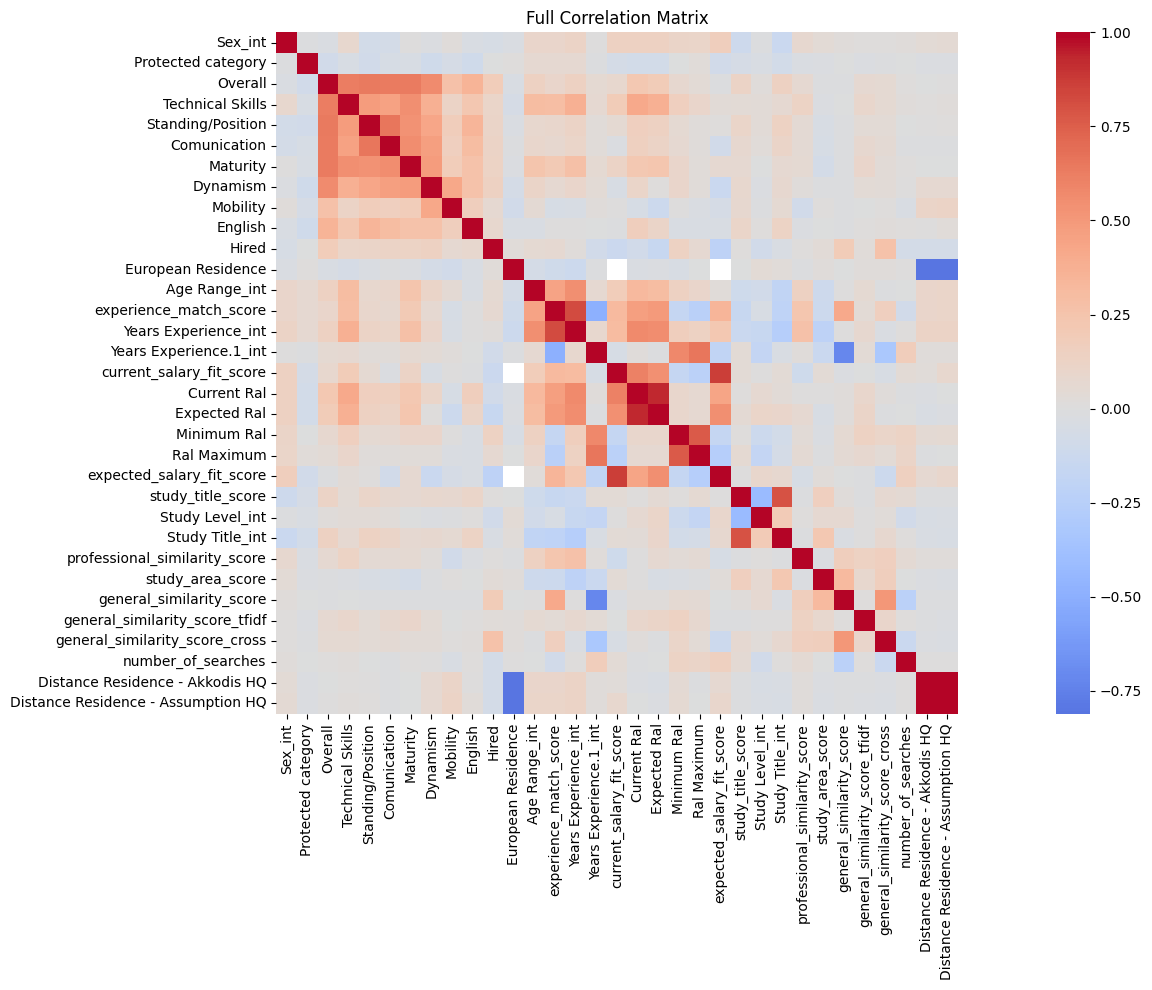

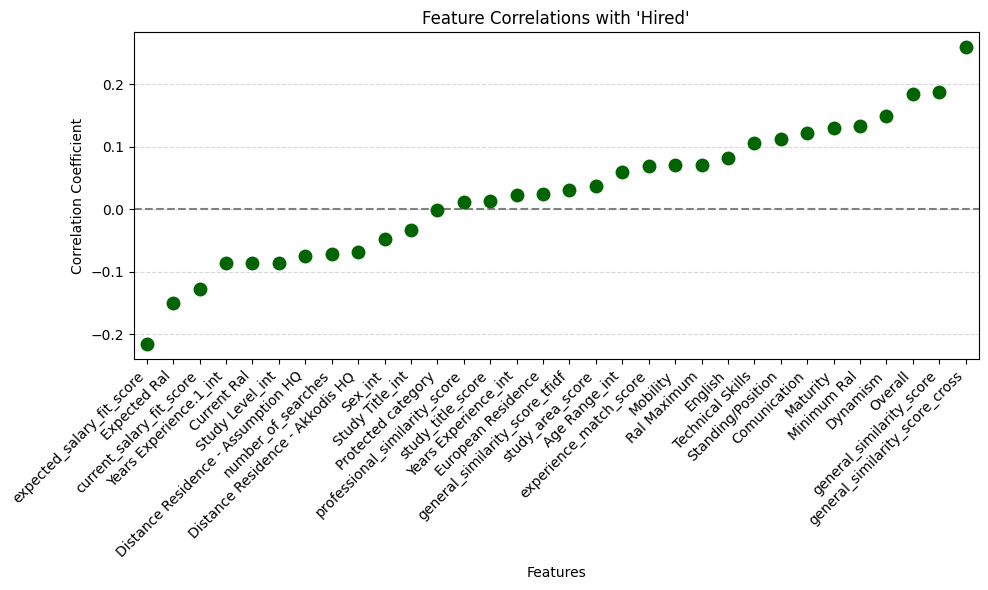

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = dataset[columns_to_keep].copy()

bool_cols = df_corr.select_dtypes(include='bool').columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

df_corr_numeric = df_corr.select_dtypes(include=[np.number])

plt.figure(figsize=(20, 10))
sns.heatmap(df_corr_numeric.corr(), annot=False, 
              cmap="coolwarm", center=0, square=True)
plt.title("Full Correlation Matrix")
plt.tight_layout()
plt.show()

correlations = df_corr_numeric.corr()['Hired'].drop('Hired').sort_values()

plt.figure(figsize=(10, 6))
sns.stripplot(y=correlations.values, x=correlations.index, color='darkgreen', size=10)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Feature Correlations with 'Hired'")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Hiring Rate by Sex:
Sex
Female    0.073779
Male      0.047324
Name: Hired, dtype: float64
Hiring Rate by European Residence:
European Residence
False    0.011364
True     0.053534
Name: Hired, dtype: float64
Hiring Rate by Italian Residence:
Italian Residence
False    0.018293
True     0.054677
Name: Hired, dtype: float64

Hiring Rate by Age Range:
Age Range
20 - 25 years    0.033821
26 - 30 years    0.050131
31 - 35 years    0.077047
36 - 40 years    0.081040
40 - 45 years    0.078199
< 20 years       0.030227
> 45 years       0.060475
Name: Hired, dtype: float64

Hiring Rate by Protected Category:
Protected category
False    0.052784
True     0.051282
Name: Hired, dtype: float64


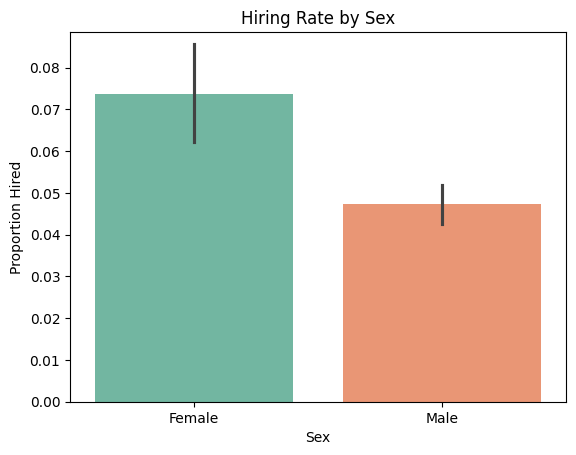

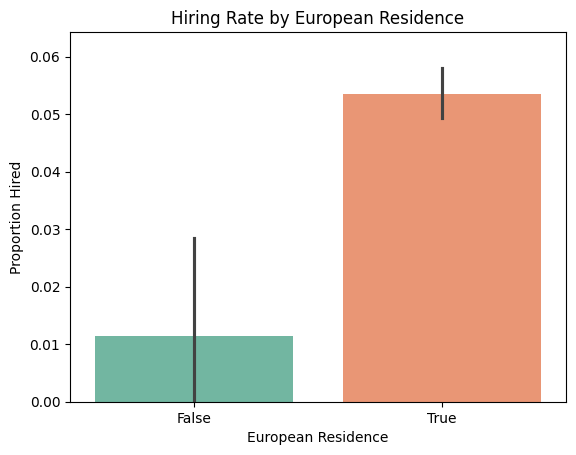

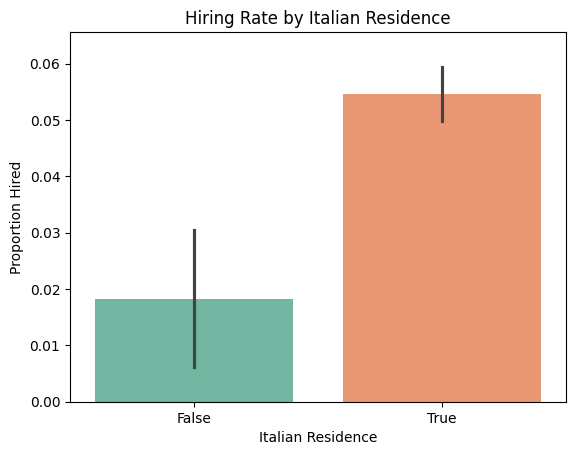

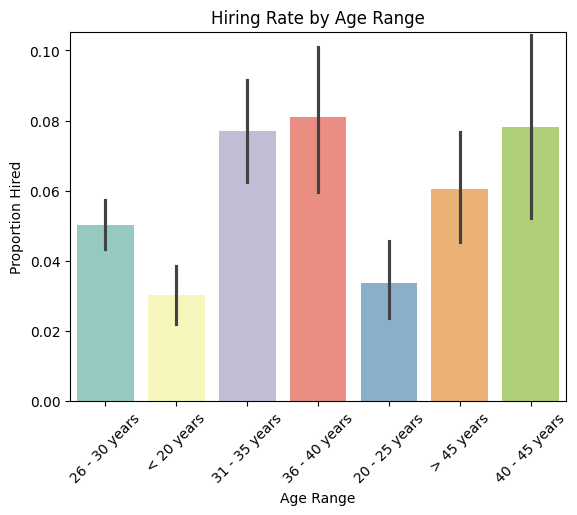

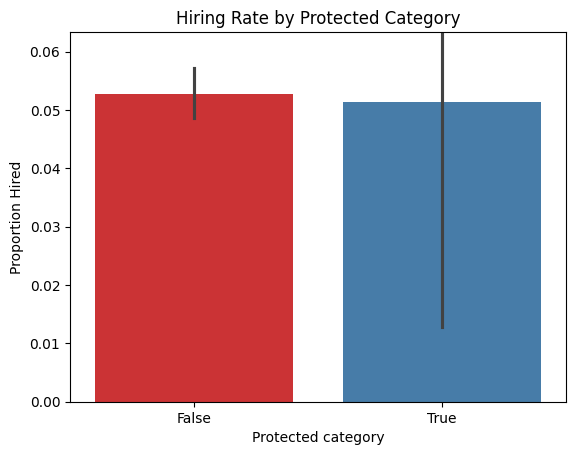

In [13]:
print("Hiring Rate by Sex:")
distribution_by_sex = dataset.groupby('Sex')['Hired'].mean()
print(distribution_by_sex)

print("Hiring Rate by European Residence:")
distribution_by_eu_residence = dataset.groupby('European Residence')['Hired'].mean()
print(distribution_by_eu_residence)

print("Hiring Rate by Italian Residence:")
distribution_by_it_residence = dataset.groupby('Italian Residence')['Hired'].mean()
print(distribution_by_it_residence)

print("\nHiring Rate by Age Range:")
distribution_by_age = dataset.groupby('Age Range')['Hired'].mean()
print(distribution_by_age)

print("\nHiring Rate by Protected Category:")
distribution_by_category = dataset.groupby('Protected category')['Hired'].mean()
print(distribution_by_category)

sns.barplot(x='Sex', y='Hired', data=dataset, estimator=np.mean, palette='Set2')
plt.title("Hiring Rate by Sex")
plt.ylim(0, 1.2 * max(distribution_by_sex))
plt.ylabel("Proportion Hired")
plt.show()

sns.barplot(x='European Residence', y='Hired', data=dataset, estimator=np.mean, palette='Set2')
plt.title("Hiring Rate by European Residence")
plt.ylim(0, 1.2 * max(distribution_by_eu_residence))
plt.ylabel("Proportion Hired")
plt.show()

sns.barplot(x='Italian Residence', y='Hired', data=dataset, estimator=np.mean, palette='Set2')
plt.title("Hiring Rate by Italian Residence")
plt.ylim(0, 1.2 * max(distribution_by_it_residence))
plt.ylabel("Proportion Hired")
plt.show()

sns.barplot(x='Age Range', y='Hired', data=dataset, estimator=np.mean, palette='Set3')
plt.title("Hiring Rate by Age Range")
plt.ylim(0, 1.3 * max(distribution_by_age))
plt.xticks(rotation=45)
plt.ylabel("Proportion Hired")
plt.show()

sns.barplot(x='Protected category', y='Hired', data=dataset, estimator=np.mean, palette='Set1')
plt.title("Hiring Rate by Protected Category")
plt.ylim(0, 1.2 * max(distribution_by_category))
plt.ylabel("Proportion Hired")
plt.show()

In [14]:
summary_sex = dataset.groupby('Sex')['Hired'].agg(['mean', 'count']).rename(columns={'mean': 'Hiring Rate', 'count': 'Number of Candidates'})
print("\nHiring Rate and Count by Sex:\n", summary_sex)

summary_eu_residence = dataset.groupby('European Residence')['Hired'].agg(['mean', 'count']).rename(columns={'mean': 'Hiring Rate', 'count': 'Number of Candidates'})
print("\nHiring Rate and Count by European Residence:\n", summary_eu_residence)

summary_it_residence = dataset.groupby('Italian Residence')['Hired'].agg(['mean', 'count']).rename(columns={'mean': 'Hiring Rate', 'count': 'Number of Candidates'})
print("\nHiring Rate and Count by Italian Residence:\n", summary_it_residence)

summary_age = dataset.groupby('Age Range')['Hired'].agg(['mean', 'count']).rename(columns={'mean': 'Hiring Rate', 'count': 'Number of Candidates'}).sort_index()
print("\nHiring Rate and Count by Age Range:\n", summary_age)

summary_protected = dataset.groupby('Protected category')['Hired'].agg(['mean', 'count']).rename(columns={'mean': 'Hiring Rate', 'count': 'Number of Candidates'})
print("\nHiring Rate and Count by Protected Category:\n", summary_protected)



Hiring Rate and Count by Sex:
         Hiring Rate  Number of Candidates
Sex                                      
Female     0.073779                  2006
Male       0.047324                  7734

Hiring Rate and Count by European Residence:
                     Hiring Rate  Number of Candidates
European Residence                                   
False                  0.011364                   176
True                   0.053534                  9564

Hiring Rate and Count by Italian Residence:
                    Hiring Rate  Number of Candidates
Italian Residence                                   
False                 0.018293                   492
True                  0.054677                  9236

Hiring Rate and Count by Age Range:
                Hiring Rate  Number of Candidates
Age Range                                       
20 - 25 years     0.033821                  1094
26 - 30 years     0.050131                  3810
31 - 35 years     0.077047                  1


Hiring Rate by Sex and Age Range:
Age Range  20 - 25 years  26 - 30 years  31 - 35 years  36 - 40 years  \
Sex                                                                     
Female          0.030612       0.068235       0.133588       0.101449   
Male            0.035000       0.044932       0.061992       0.075581   

Age Range  40 - 45 years  < 20 years  > 45 years  
Sex                                               
Female          0.134615    0.038690    0.162162  
Male            0.070270    0.027955    0.051643  


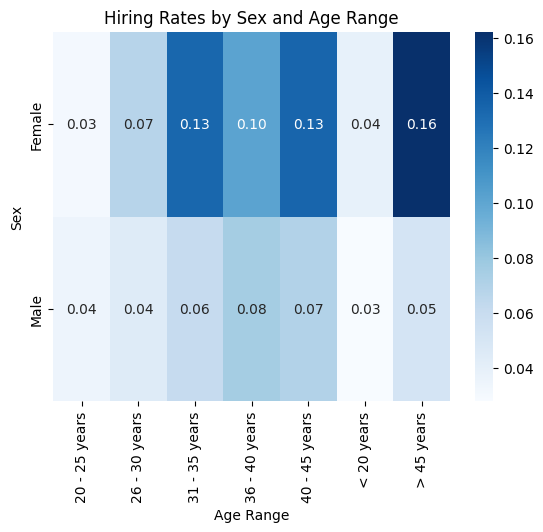

In [15]:
intersection = dataset.groupby(['Sex', 'Age Range'])['Hired'].mean().unstack()
print("\nHiring Rate by Sex and Age Range:")
print(intersection)

sns.heatmap(intersection, annot=True, cmap='Blues', fmt=".2f")
plt.title("Hiring Rates by Sex and Age Range")
plt.ylabel("Sex")
plt.xlabel("Age Range")
plt.show()

In [16]:
p_selected_female = dataset[dataset['Sex'] == 'Female']['Hired'].mean()
p_selected_male = dataset[dataset['Sex'] == 'Male']['Hired'].mean()

disparate_impact = p_selected_female / p_selected_male
print("\nDisparate Impact Ratio (Female vs Male):", round(disparate_impact, 3))


Disparate Impact Ratio (Female vs Male): 1.559


**Analysis of Hiring Rates**

**1. Gender (Sex)**
Females are hired at a significantly higher rate than males, suggesting a possible organizational emphasis on gender diversity or a potential bias favoring female candidates.

**2. Age Range**
Hiring rates increase with age, peaking between 31–45 years, indicating a clear preference for mid-career professionals with more experience. Younger candidates, especially under 26, face notably lower hiring chances.

**3. European Residence**
Candidates residing in Europe are far more likely to be hired, which may reflect logistical preferences, legal work eligibility, or alignment with company locations and operations.

**4. Italian Residence**
There is a strong hiring bias toward candidates living in Italy. This suggests the organization prefers local hires, potentially to reduce relocation costs or due to legal/employment constraints.

**5. Protected Category**
No meaningful difference in hiring rates between protected and non-protected groups was found. However, due to the very small sample of protected category candidates, no reliable conclusion can be drawn.

### Drop Nan Values

In [17]:
import pandas as pd

df = dataset.copy()

print(f"{'Column':30} | {'Rows Before':10} | {'Rows After':10} | {'Hired Before':12} | {'Hired After':11} | {'% Hired Before':14} | {'% Hired After':13}")
print("-" * 105)

rows_before = len(df)
hired_before = df['Hired'].sum()
perc_hired_before = hired_before / rows_before * 100

for col in columns_to_keep:
    df_dropped = df.dropna(subset=[col])
    
    rows_after = len(df_dropped)
    hired_after = df_dropped['Hired'].sum()
    
    perc_hired_after = hired_after / rows_after * 100 if rows_after > 0 else 0
    
    print(f"{col:30} | {rows_before:<10} | {rows_after:<10} | {hired_before:<12} | {hired_after:<11} | {perc_hired_before:<14.2f} | {perc_hired_after:<13.2f}")


Column                         | Rows Before | Rows After | Hired Before | Hired After | % Hired Before | % Hired After
---------------------------------------------------------------------------------------------------------
Sex_int                        | 9740       | 9740       | 514          | 514         | 5.28           | 5.28         
Protected category             | 9740       | 9740       | 514          | 514         | 5.28           | 5.28         
Overall                        | 9740       | 4410       | 514          | 509         | 5.28           | 11.54        
Technical Skills               | 9740       | 4398       | 514          | 509         | 5.28           | 11.57        
Standing/Position              | 9740       | 4398       | 514          | 509         | 5.28           | 11.57        
Comunication                   | 9740       | 4398       | 514          | 509         | 5.28           | 11.57        
Maturity                       | 9740       | 4398       | 5

In [18]:
df_cleaned = dataset.dropna(subset=[ 'professional_similarity_score', ])

print(f"Original data shape: {dataset.shape,(dataset['Hired']==True).sum()}")
print(f"Cleaned data shape: {df_cleaned.shape,(df_cleaned['Hired']==True).sum()}")


Original data shape: ((9740, 58), np.int64(514))
Cleaned data shape: ((4425, 58), np.int64(471))


#### Save Cleaned Dataset

In [19]:
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

## Training

#### Load Cleaned Dataset

In [20]:
import pandas as pd

df_cleaned = pd.read_csv('cleaned_dataset.csv')

### Models Comparison


Training Data Results:

Results for Downsample Sampling (Training Data):
               Model  F1 Score  Accuracy  Precision   Recall
HistGradientBoosting  1.000000  1.000000   1.000000 1.000000
             XGBoost  1.000000  1.000000   1.000000 1.000000
            LightGBM  1.000000  1.000000   1.000000 1.000000
            CatBoost  1.000000  1.000000   1.000000 1.000000
            Ensemble  1.000000  1.000000   1.000000 1.000000
          BalancedRF  1.000000  1.000000   1.000000 1.000000
        RandomForest  0.990777  0.990716   0.984293 0.997347
  LogisticRegression  0.780952  0.786472   0.801676 0.761273

Results for Original Sampling (Training Data):
               Model  F1 Score  Accuracy  Precision   Recall
HistGradientBoosting  1.000000  1.000000   1.000000 1.000000
             XGBoost  1.000000  1.000000   1.000000 1.000000
            Ensemble  0.998675  0.999718   0.997354 1.000000
            CatBoost  0.993412  0.998589   0.986911 1.000000
            LightGBM  0.

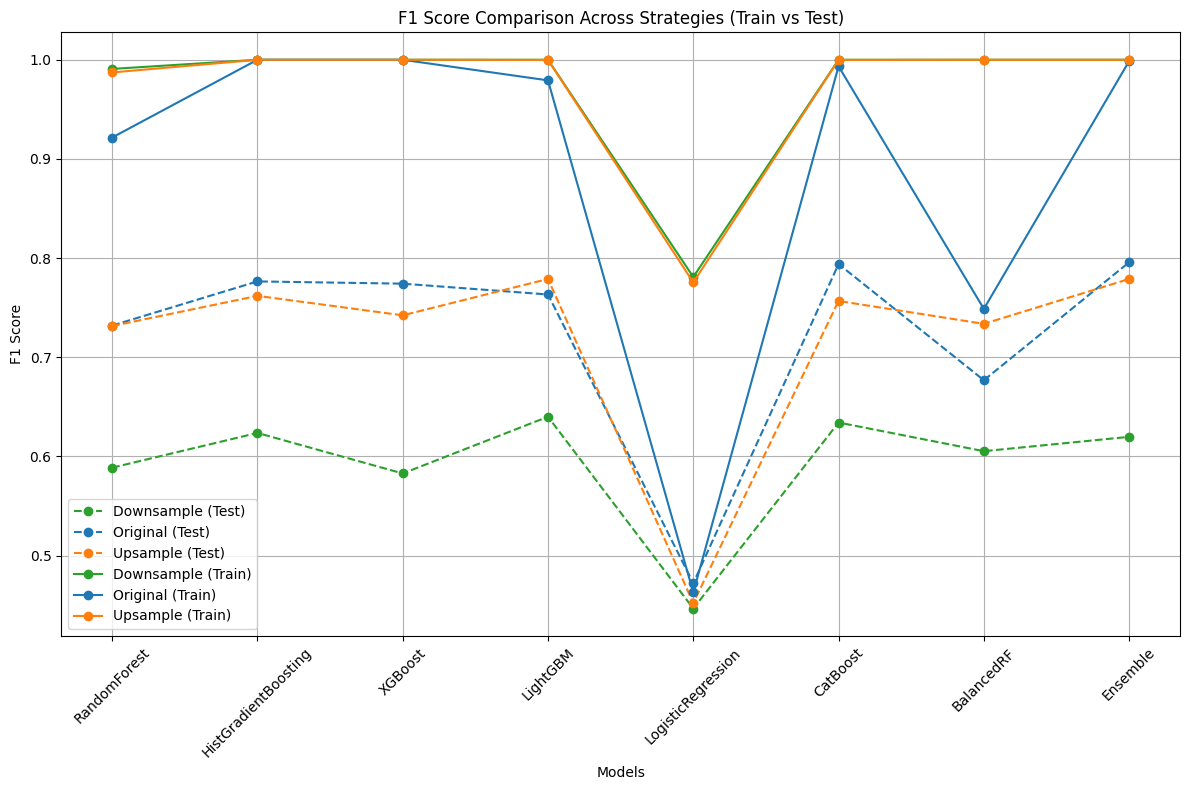

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

random_state = 42

df = df_cleaned[columns_to_keep].copy()
X = df.drop(columns=['Hired'])
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = [c for c in X.columns.difference(bool_cols) if c != 'Sex_int']
X[bool_cols] = X[bool_cols].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)
scaler = StandardScaler()
X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_upsampled, y_train_upsampled = ADASYN(random_state=random_state).fit_resample(X_train_imputed, y_train)
downsampler_impl = RandomUnderSampler(sampling_strategy='majority', random_state=random_state)
X_train_downsampled, y_train_downsampled = downsampler_impl.fit_resample(X_train_imputed, y_train)

models = {
    'RandomForest': lambda: RandomForestClassifier(class_weight='balanced', random_state=random_state, max_depth=10, min_samples_split=5, n_estimators=100),
    'HistGradientBoosting': lambda: HistGradientBoostingClassifier(random_state=random_state),
    'XGBoost': lambda: XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=random_state, eval_metric='logloss', max_depth=6),
    'LightGBM': lambda: LGBMClassifier(class_weight='balanced', random_state=random_state, max_depth=6, min_data_in_leaf=20, verbosity=-1),
    'LogisticRegression': lambda: LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=0.1, solver='liblinear', random_state=random_state),
    'CatBoost': lambda: CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=random_state, l2_leaf_reg=3, iterations=500, depth=6, learning_rate=0.05),
    'BalancedRF': lambda: BalancedRandomForestClassifier(random_state=random_state)
}

ensemble = lambda: VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']()),
        ('lgbm', models['LightGBM']()),
        ('cat', models['CatBoost']()),
        ('hist', models['HistGradientBoosting']()),
        ('brf', models['BalancedRF']())
    ],
    voting='soft'
)
models['Ensemble'] = ensemble

results_train = {}
results_test = {}

for strategy_name in ['Downsample', 'Original', 'Upsample']:
    strategy_results_train = []
    strategy_results_test = []
    
    for model_name, model in models.items():
        model = model()
        if strategy_name == 'Original':
            if model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
                X_tr = X_train
                y_tr = y_train
                X_te = X_test
            else:
                X_tr = X_train_imputed
                y_tr = y_train
                X_te = X_test_imputed
        elif strategy_name == 'Upsample':
            X_tr = X_train_upsampled
            y_tr = y_train_upsampled
            X_te = X_test_imputed
        elif strategy_name == 'Downsample':
            X_tr = X_train_downsampled
            y_tr = y_train_downsampled
            X_te = X_test_imputed  
    
        model.fit(X_tr, y_tr)
        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)
        
        strategy_results_train.append([
            model_name,
            f1_score(y_tr, y_pred_train),
            accuracy_score(y_tr, y_pred_train),
            precision_score(y_tr, y_pred_train),
            recall_score(y_tr, y_pred_train)
        ])
        
        strategy_results_test.append([
            model_name,
            f1_score(y_test, y_pred_test),
            accuracy_score(y_test, y_pred_test),
            precision_score(y_test, y_pred_test),
            recall_score(y_test, y_pred_test)
        ])
    
    results_train[strategy_name] = pd.DataFrame(strategy_results_train, columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])
    results_test[strategy_name] = pd.DataFrame(strategy_results_test, columns=['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall'])

print("\nTraining Data Results:")
for strategy_name, result_df in results_train.items():
    print(f"\nResults for {strategy_name} Sampling (Training Data):")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

print("\nTest Data Results:")
for strategy_name, result_df in results_test.items():
    print(f"\nResults for {strategy_name} Sampling (Test Data):")
    print(result_df.sort_values(by='F1 Score', ascending=False).to_string(index=False))

strategy_colors = {
    'Original': sns.color_palette("tab10")[0],
    'Upsample': sns.color_palette("tab10")[1],
    'Downsample': sns.color_palette("tab10")[2],
}

plt.figure(figsize=(12, 8))

for strategy_name, result_df in results_test.items():
    color = strategy_colors[strategy_name]
    plt.plot(result_df['Model'], result_df['F1 Score'], label=f"{strategy_name} (Test)", marker='o', linestyle='--', color=color)

for strategy_name, result_df in results_train.items():
    color = strategy_colors[strategy_name]
    plt.plot(result_df['Model'], result_df['F1 Score'], label=f"{strategy_name} (Train)", marker='o', linestyle='-', color=color)

plt.title('F1 Score Comparison Across Strategies (Train vs Test)')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Summary

- **Ensemble** consistently outperforms other models on **test data** across all sampling strategies, achieving the **highest F1 scores** (up to 0.80 with original dataset).

- **LightGBM**, **HistGradientBoosting**, **XGBoost** and **CatBoost** models also perform well, particularly with original and upsampled data.

- **RandomForest** and **BalancedRF** show solid performance but slightly trail behind the top models.

- **BalancedRF** benefits most from upsampling but underperforms with original and downsampled data.

- **Logistic Regression** lags across all settings, confirming that more complex models handle the task better.

> All models show perfect or near-perfect results on training data, indicating **clear overfitting**, likely due to the **limited dataset size**.


### Features Removal Comparison

In [64]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def compare_feature_sets(feature_sets, test_models):
    results = []

    for feat_set_name, feat_cols in tqdm(feature_sets.items(), desc='Feature sets'):
        X_sub = df_cleaned[feat_cols].copy()
        y_sub = df_cleaned['Hired']

        bool_cols = X_sub.select_dtypes(include='bool').columns
        non_bool_cols = X_sub.columns.difference(bool_cols)

        X_sub[bool_cols] = X_sub[bool_cols].astype(int)

        X_train, X_test, y_train, y_test = train_test_split(
            X_sub, y_sub, stratify=y_sub, test_size=0.2, random_state=random_state
        ) 
        scaler = StandardScaler()
        X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
        X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
        X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

        for model_name, model_lambda in test_models.items():
            model = model_lambda()
            if model_name in ['LightGBM', 'CatBoost']:
                X_tr = X_train
                X_te = X_test
            else:
                X_tr = X_train_imputed
                X_te = X_test_imputed
            model.fit(X_tr, y_train)
            y_pred_test = model.predict(X_te)
            y_pred_train = model.predict(X_tr)
            f1_test = f1_score(y_test, y_pred_test)
            f1_train = f1_score(y_train, y_pred_train)
            results.append({
                'Feature Set': feat_set_name,
                'Model': model_name,
                'Train F1': f1_train,
                'Test F1': f1_test
            })

    results_df = pd.DataFrame(results)

    best_row = results_df.loc[results_df['Test F1'].idxmax()]
    print(f"\nBest performance:\nFeature Set: {best_row['Feature Set']}, Model: {best_row['Model']}, F1 Score: {best_row['Test F1']:.4f}")
    return results_df

In [65]:
feature_columns = [col for col in columns_to_keep if col != 'Hired']

feature_sets = {
    'general_similarity_score_cross': [col for col in feature_columns if col not in ['general_similarity_score', 'general_similarity_score_tfidf']],
    'general_similarity_score': [col for col in feature_columns if col not in ['general_similarity_score_tfidf', 'general_similarity_score_cross']],
    'general_similarity_score_tfidf': [col for col in feature_columns if col not in ['general_similarity_score', 'general_similarity_score_cross']],
    'None ':  [col for col in feature_columns if col not in ['general_similarity_score_tfidf', 'general_similarity_score', 'general_similarity_score_cross']], 
    'all': feature_columns,
    }

test_models = {
    "LightGBM":models['LightGBM'],
    'CatBoost': models['CatBoost'],
    'Ensemble': models['Ensemble'],
}

results_df = compare_feature_sets(feature_sets, test_models)
results_df

Feature sets: 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]


Best performance:
Feature Set: general_similarity_score, Model: Ensemble, F1 Score: 0.7959


,Feature Set,Model,Train F1,Test F1
0,general_similarity_score_cross,LightGBM,0.946048,0.767773
1,general_similarity_score_cross,CatBoost,0.977951,0.766990
2,general_similarity_score_cross,Ensemble,0.994723,0.766169
3,general_similarity_score,LightGBM,0.959288,0.759259
4,general_similarity_score,CatBoost,0.994723,0.766169
5,general_similarity_score,Ensemble,0.997354,0.795918
6,general_similarity_score_tfidf,LightGBM,0.919512,0.745455
7,general_similarity_score_tfidf,CatBoost,0.976684,0.751220
8,general_similarity_score_tfidf,Ensemble,0.996037,0.790244
9,None,LightGBM,0.930864,0.745455


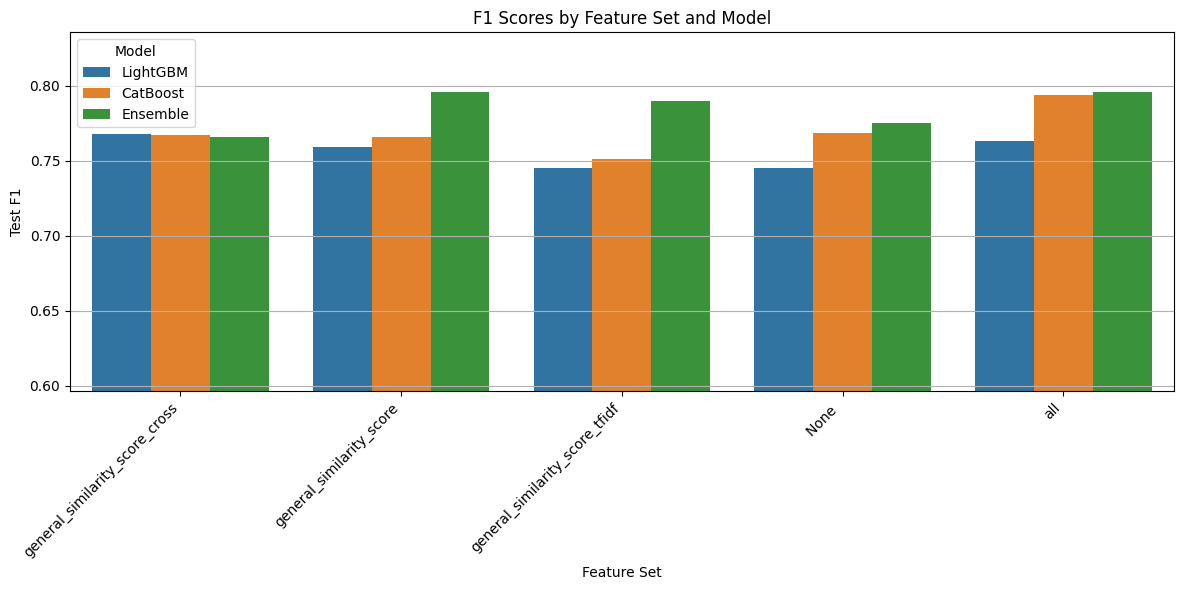

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Feature Set", y="Test F1", hue="Model")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.8*min(results_df['Test F1']))
plt.title("F1 Scores by Feature Set and Model")
plt.tight_layout()
plt.legend(title="Model")
plt.grid(axis='y')

plt.show()

#### Feature Set Comparison Summary

The best performance (F1 = 0.796) was achieved using **only the `general_similarity_score` feature** with the Ensemble model. This suggests that deep semantic similarity captured through a bi-encoder model can provide a highly effective signal for predicting hires, even if it's not consistently the best across all models.

- **`general_similarity_score`** uses a SentenceTransformer encoder and cosine similarity to capture deep semantic relationships.
- **`general_similarity_score_cross`** leverages a cross-encoder transformer that jointly processes candidate and job texts, allowing for nuanced contextual matching.
- **`general_similarity_score_tfidf`** calculates cosine similarity between TF-IDF vectors, highlighting surface-level lexical overlap.

Both the `general_similarity_score_cross` and `all` feature sets also produced **strong and consistent results** across multiple models, demonstrating the robustness of combining similarity signals. In particular, `general_similarity_score_cross` often yielded reliable performance, though it did **not outperform** the peak result from `general_similarity_score` with the Ensemble model.

Notably, excluding all similarity features leads to a significant drop in F1 (e.g., Ensemble F1 falls to 0.775), emphasizing the importance of text similarity for this task.

Given that `general_similarity_score` achieves the **highest single F1 score**, even if not consistently the best across all settings, we opt to use **only `general_similarity_score`** in the final model. This choice balances performance with simplicity and computational efficiency, while capturing the strongest individual signal observed.


In [69]:
feature_sets = {
    "base_attributes": [
        "Sex_int",
        "Protected category",
        "Overall",
        "Technical Skills",
        "Standing/Position",
        "Comunication",
        "Maturity",
        "Dynamism",
        "Mobility",
        "English",
        "Italian Residence",
        "European Residence",
        "Age Range_int",
        "Years Experience_int",
        "Years Experience.1_int",
        "Current Ral",
        "Expected Ral",
        "Minimum Ral",
        "Ral Maximum",
        "Study Level_int",
        "Study Title_int",
        "number_of_searches",
    ],
    "custom_scores": [
        "experience_match_score",
        "current_salary_fit_score",
        "expected_salary_fit_score",
        "study_title_score",
        "professional_similarity_score",
        "study_area_score",
        "general_similarity_score",
        "Distance Residence - Akkodis HQ",
        "Distance Residence - Assumption HQ",
    ],
    "custom_scores_with_essential_base_attributes": [
        # Base Attributes
        "Sex_int",
        "Protected category",
        "Overall",
        "Technical Skills",
        "Standing/Position",
        "Comunication",
        "Maturity",
        "Dynamism",
        "Mobility",
        "English",
        "Italian Residence",
        "European Residence",
        "Age Range_int",
        "number_of_searches",
        # Custom Similarity Scores
        "experience_match_score",
        "current_salary_fit_score",
        "expected_salary_fit_score",
        "study_title_score",
        "professional_similarity_score",
        "study_area_score",
        "general_similarity_score",
        "Distance Residence - Akkodis HQ",
        "Distance Residence - Assumption HQ",
    ],
    "base_attributes_with_essential_custom_scores": [
        # Base Attributes
        "Sex_int",
        "Protected category",
        "Overall",
        "Technical Skills",
        "Standing/Position",
        "Comunication",
        "Maturity",
        "Dynamism",
        "Mobility",
        "English",
        "Italian Residence",
        "European Residence",
        "Age Range_int",
        "number_of_searches",
        # Essential Custom Similarity Scores
        "study_area_score",
        "general_similarity_score",
        "Distance Residence - Akkodis HQ",
        "Distance Residence - Assumption HQ",
        # Additional Base Attributes
        "Years Experience_int",
        "Years Experience.1_int",
        "Current Ral",
        "Expected Ral",
        "Minimum Ral",
        "Ral Maximum",
        "Study Level_int",
        "Study Title_int",
    ],
    "all": [
        # Base Attributes
        "Sex_int",
        "Protected category",
        "Overall",
        "Technical Skills",
        "Standing/Position",
        "Comunication",
        "Maturity",
        "Dynamism",
        "Mobility",
        "English",
        "Italian Residence",
        "European Residence",
        "Age Range_int",
        "number_of_searches", 
        # Custom Similarity Scores
        "experience_match_score",
        "expected_salary_fit_score",
        "current_salary_fit_score",
        "professional_similarity_score",
        "study_area_score",
        "general_similarity_score",
        "study_title_score",
        "Distance Residence - Akkodis HQ",
        "Distance Residence - Assumption HQ",
        # Additional Base Attributes
        "Years Experience_int",
        "Years Experience.1_int",
        "Current Ral",
        "Expected Ral",
        "Minimum Ral",
        "Ral Maximum",
        "Study Level_int",
        "Study Title_int",  
    ],
}
results_df = compare_feature_sets(feature_sets, test_models)
results_df

Feature sets: 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


Best performance:
Feature Set: all, Model: CatBoost, F1 Score: 0.8079


,Feature Set,Model,Train F1,Test F1
0,base_attributes,LightGBM,0.826754,0.700422
1,base_attributes,CatBoost,0.943680,0.700935
2,base_attributes,Ensemble,0.970399,0.695238
3,custom_scores,LightGBM,0.798694,0.525424
4,custom_scores,CatBoost,0.892308,0.480769
5,custom_scores,Ensemble,0.954430,0.510638
6,custom_scores_with_essential_base_attributes,LightGBM,0.933168,0.767123
7,custom_scores_with_essential_base_attributes,CatBoost,0.990802,0.790244
8,custom_scores_with_essential_base_attributes,Ensemble,0.996037,0.800000
9,base_attributes_with_essential_custom_scores,LightGBM,0.955640,0.739336


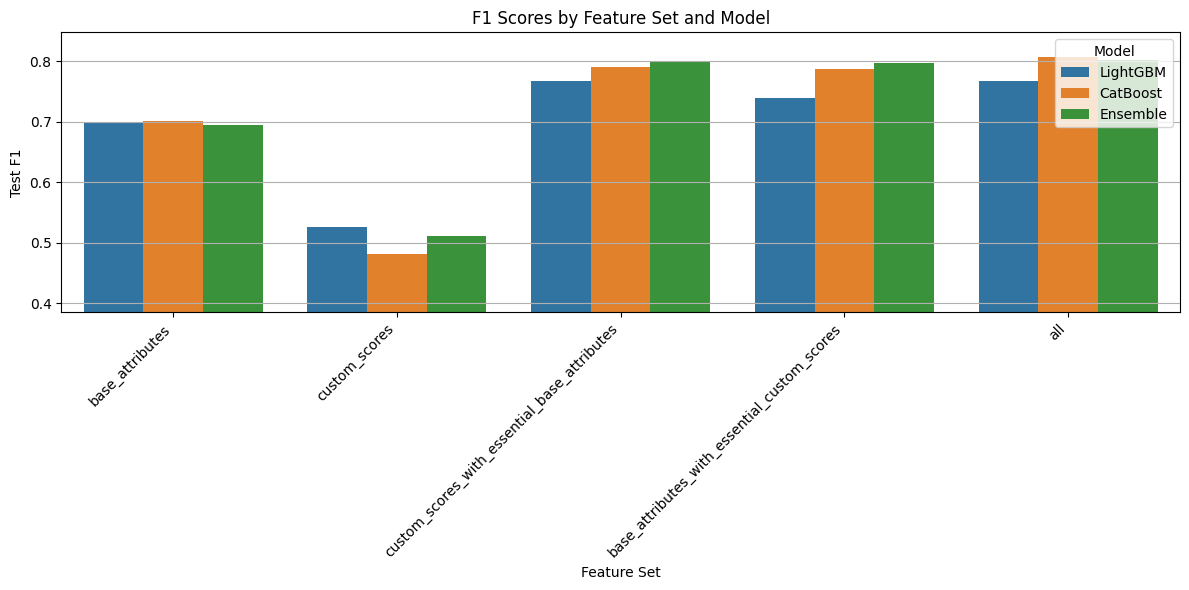

In [68]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Feature Set", y="Test F1", hue="Model")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.8*min(results_df['Test F1']))
plt.title("F1 Scores by Feature Set and Model")
plt.tight_layout()
plt.legend(title="Model")
plt.grid(axis='y')

plt.show()

#### Feature Set Comparison Summary

The best performance is achieved with the **`all`** feature set using the **CatBoost model**, reaching a **Test F1 Score of 0.8079**.

Summary of the tested feature sets:

- **base_attributes**  
  Encompasses a comprehensive set of features describing both the **candidate** (e.g., age, residence, language, education, experience) and the **job requirements or evaluations** (e.g., technical skills, position, salary ranges, overall fit scores).  
  This foundational information captures the context of both parties but lacks direct indicators of compatibility between them. Performance is moderate as a result.

- **custom_scores**  
  Focuses exclusively on engineered features that **quantify the match** between candidate and job — including salary fit, study alignment, professional similarity, and location distance.  
  These scores alone underperform, suggesting that without descriptive context, match scores don't provide enough standalone signal.

- **custom_scores_with_essential_base_attributes**  
  Builds on the custom similarity scores by integrating **critical base attributes** that anchor the match in relevant candidate-job context (like key demographics and job-related features).  
  This hybrid set performs very well, offering a balance between match precision and contextual understanding.

- **base_attributes_with_essential_custom_scores**  
  Starts with a rich base attribute set and adds only the **most important custom scores** (e.g., general similarity, location distance).  
  It effectively reinforces candidate-job context with minimal additional complexity, also producing strong results.

- **all**  
  Combines **every available feature** into one comprehensive set — including all base attributes and all custom scores.  
  While this approach slightly edges out others in performance, the marginal gain may not justify the added feature redundancy and risk of overfitting.

> **Conclusion:** While the `all` feature set shows the highest F1 score, we select the **`custom_scores_with_essential_base_attributes`** feature set as the optimal choice. It provides nearly equivalent performance with fewer features, reducing complexity and redundancy. These results also highlight that:
> - **Base attributes alone** are not sufficient, as they lack direct match indicators.
> - **Custom similarity scores alone** are also insufficient, as they lack foundational context.
> - The best results come from combining **custom match scores** with **key descriptive features**, ensuring both **contextual grounding** and **match relevance**.


### Sampling Techniques

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler


df = df_cleaned[feature_sets['custom_scores_with_essential_base_attributes']+['Hired']].copy()
X = df.drop(columns=['Hired'])
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = X.columns.difference(bool_cols)

X[bool_cols] = X[bool_cols].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=random_state
)
scaler = StandardScaler()
X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])

imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_orig, y_orig = X_train_imputed, y_train

minority_count = sum(y_orig == 1)
majority_count = sum(y_orig == 0)

smote_ratios = [0.25, 0.5, 0.75, 1.0]

resampled_datasets = {}

resampled_datasets['Original'] = {'imputed': (X_orig, y_orig, X_test_imputed), 'original': (X_train, y_train, X_test)}

for ratio in smote_ratios:
    name = f'SMOTE_{int(ratio*100)}%'
    smote = SMOTE(sampling_strategy=ratio, random_state=random_state)
    X_res, y_res = smote.fit_resample(X_orig, y_orig)
    resampled_datasets[name] = (X_res, y_res)

for ratio in smote_ratios:
    name = f'ADASYN_{int(ratio*100)}%'
    adasyn = ADASYN(sampling_strategy=ratio, random_state=random_state)
    X_res, y_res = adasyn.fit_resample(X_orig, y_orig)
    resampled_datasets[name] = (X_res, y_res)

for ratio in smote_ratios:
    name = f'BorderlineSMOTE_{int(ratio*100)}%'
    bl_smote = BorderlineSMOTE(sampling_strategy=ratio, random_state=random_state)
    X_res, y_res = bl_smote.fit_resample(X_orig, y_orig)
    resampled_datasets[name] = (X_res, y_res)

for ratio in smote_ratios:
    name = f'SVMSMOTE_{int(ratio*100)}%'
    svm_smote = SVMSMOTE(sampling_strategy=ratio, random_state=random_state)
    X_res, y_res = svm_smote.fit_resample(X_orig, y_orig)
    resampled_datasets[name] = (X_res, y_res)

resampled_datasets['Downsampling'] = RandomUnderSampler(random_state=random_state).fit_resample(X_orig, y_orig)

results = []

for strategy_name, trainset in tqdm(resampled_datasets.items(), desc='Training...'):
    for model_name, model_lambda in test_models.items():
        if strategy_name == 'Original':
            if model_name in ['LightGBM', 'CatBoost']:
                X_tr, y_tr, X_te = trainset['original']
            else: 
                X_tr, y_tr, X_te = trainset['imputed']
        else:
            (X_tr, y_tr) = trainset
            X_te = X_test_imputed
        model = model_lambda()
        model.fit(X_tr, y_tr)
        y_pred_test = model.predict(X_te)
        y_pred_train = model.predict(X_tr)
        f1_test = f1_score(y_test, y_pred_test)
        f1_train = f1_score(y_tr, y_pred_train)
        results.append({
            'Resampling': strategy_name,
            'Model': model_name,
            'Train F1': f1_train,
            'Test F1': f1_test
        })

results_df = pd.DataFrame(results)
results_df

Training...: 100%|██████████| 18/18 [02:26<00:00,  8.14s/it]


,Resampling,Model,Train F1,Test F1
0,Original,LightGBM,0.933168,0.767123
1,Original,CatBoost,0.990802,0.790244
2,Original,Ensemble,0.996037,0.800000
3,SMOTE_25%,LightGBM,0.977146,0.792453
4,SMOTE_25%,CatBoost,0.991850,0.780488
5,SMOTE_25%,Ensemble,0.999368,0.803922
6,SMOTE_50%,LightGBM,0.992774,0.800000
7,SMOTE_50%,CatBoost,0.998423,0.763819
8,SMOTE_50%,Ensemble,1.000000,0.800000
9,SMOTE_75%,LightGBM,0.995798,0.795918


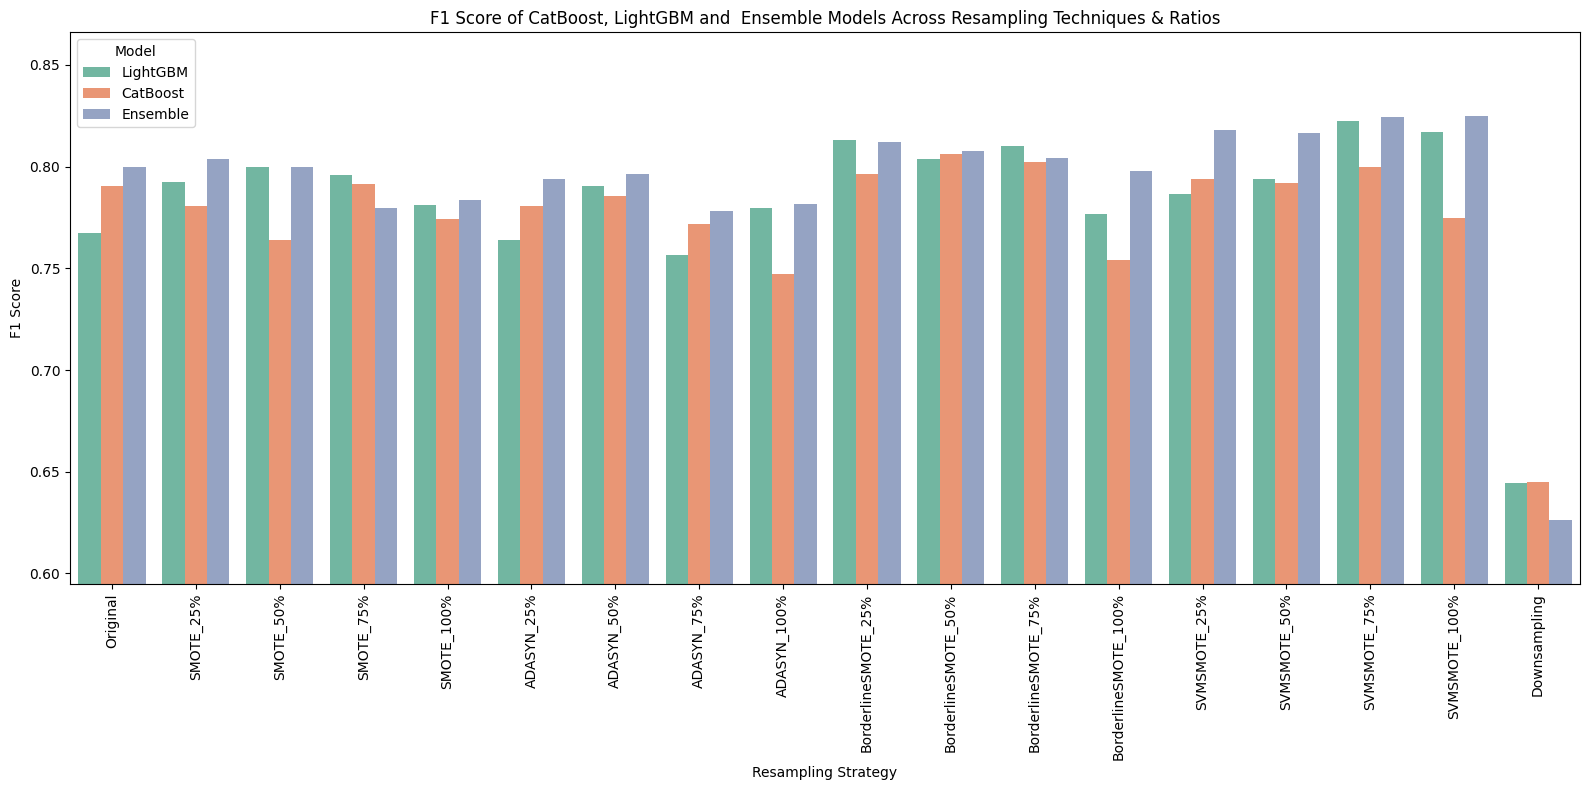

In [73]:
min_f1 = results_df['Test F1'].min()

plt.figure(figsize=(16, 8))
sns.barplot(
    data=results_df,
    x='Resampling',
    y='Test F1',
    hue='Model',
    palette='Set2'
)
plt.title('F1 Score of CatBoost, LightGBM and  Ensemble Models Across Resampling Techniques & Ratios')
plt.xticks(rotation=90)
plt.ylabel('F1 Score')
plt.ylim(bottom=0.95 * min_f1)
plt.xlabel('Resampling Strategy')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

#### Resampling Strategy Comparison Summary

This experiment compared various resampling techniques to mitigate class imbalance, evaluating their impact on **CatBoost**, **LightGBM**, and **Ensemble** models based on Train and Test F1 scores.

##### Best Performance
- **Top Result:** `SVMSMOTE_75%` with **Ensemble** (Test F1 = **0.8241**)

##### Final Choice: `SMOTE_75%`
We select **SMOTE with 75% ratio** as the preferred resampling strategy due to its **strong performance** and **balanced data augmentation**:

- **Robust Test F1 Scores**:
  - LightGBM F1 = **0.8223**
  - CatBoost F1 = **0.8000**
  - Ensemble F1 = **0.8241**
- **Improved Generalization** compared to lower SMOTE ratios (25%, 50%) and original data.
- **Controlled synthetic sample generation** avoids overfitting seen at 100% oversampling levels.

##### How Sampling Ratio Affects Performance

- **Original dataset (no resampling)** provides a solid baseline with moderate test F1 scores (LightGBM: 0.7671, CatBoost: 0.7902, Ensemble: 0.8000), but the class imbalance limits further improvement.
- **Lower SMOTE ratios (25%, 50%)** improve Test F1 compared to the original dataset by alleviating class imbalance but may still under-represent the minority class, limiting gains.
- **At 75% oversampling**, the minority class is better represented, leading to improved model generalization and higher F1 scores across models.
- **Increasing to 100% oversampling** tends to introduce noise and redundancy in synthetic samples, causing slight performance drops, especially visible in CatBoost and Ensemble results.
- More complex resampling techniques like **SVMSMOTE** and **BorderlineSMOTE** show competitive or better performance at some ratios but come with increased computational cost and complexity.

##### Key Observations

- **Original data** shows that imbalance restricts maximum achievable performance despite strong training F1 scores.
- **SMOTE_75%** strikes the best balance between addressing class imbalance and avoiding overfitting or noise.
- **SVMSMOTE_75%** achieves the highest overall Test F1 with the Ensemble but at greater complexity.
- **ADASYN** methods deliver reasonable but less consistent results.
- **Downsampling** drastically reduces test performance despite perfect training scores, indicating overfitting.

> **Conclusion:**  
We select **SMOTE with a 75% oversampling ratio** as the optimal resampling strategy. It effectively balances minority class representation and avoids overfitting, leading to strong and consistent predictive performance across models while maintaining manageable computational costs.


### Fairness Metrics

In [77]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference
)
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = df_cleaned.copy()

protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]

df = df.dropna(subset=protected_attributes).reset_index(drop=True)

X = df.drop(columns=['Hired'])[feature_sets['custom_scores_with_essential_base_attributes']]
y = df['Hired']

bool_cols = X.select_dtypes(include='bool').columns
non_bool_cols = X.columns.difference(bool_cols)

X[bool_cols] = X[bool_cols].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

scaler = StandardScaler()
X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])

imputer = SimpleImputer(strategy='mean')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

svm_smote = SMOTE(sampling_strategy=0.75, random_state=random_state)
X_res, y_res = svm_smote.fit_resample(X_train_imp, y_train)

majority_count = (y_res == 0).sum()
minority_count = (y_res == 1).sum()

catboost_model = models['CatBoost']()
lightgbm_model = models['LightGBM']()
ensemble_model = models['Ensemble']()

catboost_model.fit(X_res, y_res)
lightgbm_model.fit(X_res, y_res)
ensemble_model.fit(X_res, y_res)


y_pred_cat = catboost_model.predict(X_test_imp)
y_pred_lgb = lightgbm_model.predict(X_test_imp)
y_pred_ens = ensemble_model.predict(X_test_imp)

performance_results = []
fairness_results = []

for model_name, y_pred in [('CatBoost', y_pred_cat), ('LightGBM', y_pred_lgb), ('Ensemble', y_pred_ens)]:
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    performance_results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall
    })
    
    for attr in protected_attributes:
        sensitive_features_test = dataset.loc[X_test.index, attr]
        dp_diff = demographic_parity_difference(
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=sensitive_features_test
        )
    
        eo_diff = equalized_odds_difference(
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=sensitive_features_test
        )
        
        fairness_results.append({
            'Model': model_name, 
            'Attribute': attr,
            'Demographic Parity Diff': dp_diff,
            'Equalized Odds Diff': eo_diff
        })


performance_df = pd.DataFrame(performance_results)
fairness_df = pd.DataFrame(fairness_results)

long_perf_df = pd.melt(
    performance_df,
    id_vars=['Model'],
    value_vars=['Precision', 'Recall'],
    var_name='Metric',
    value_name='Score'
)

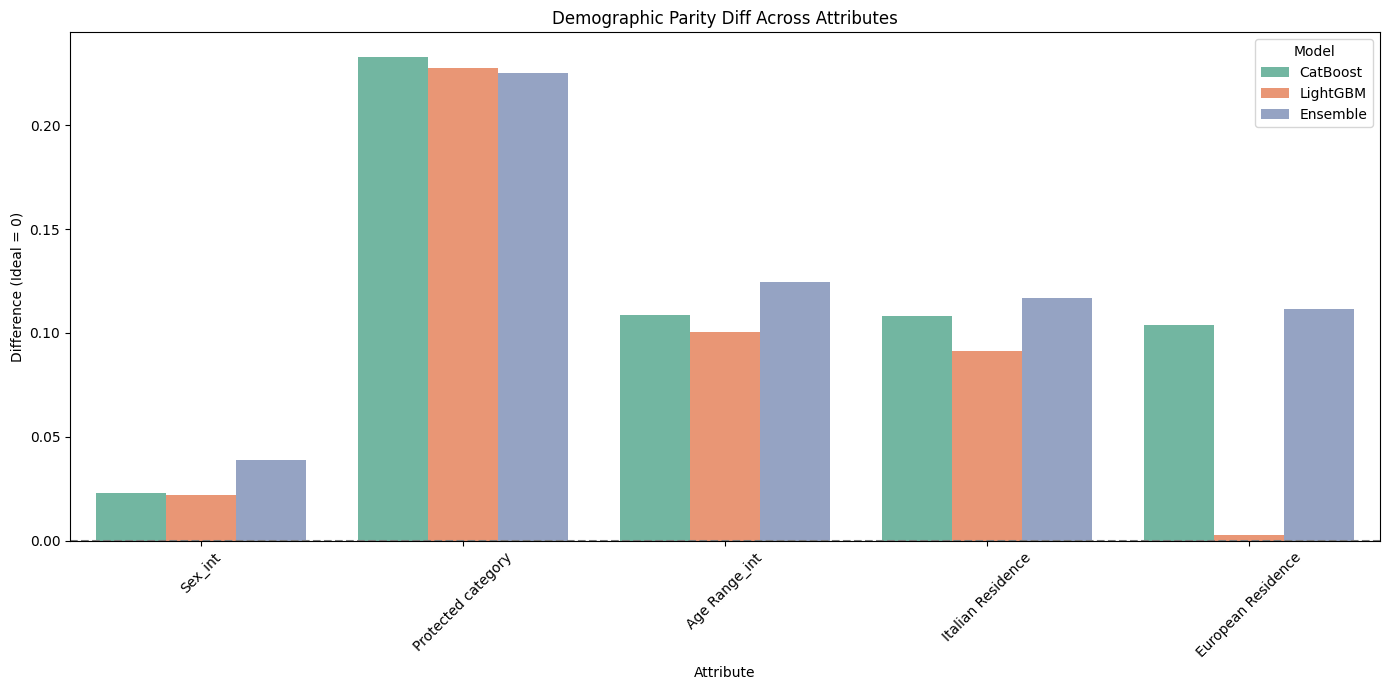

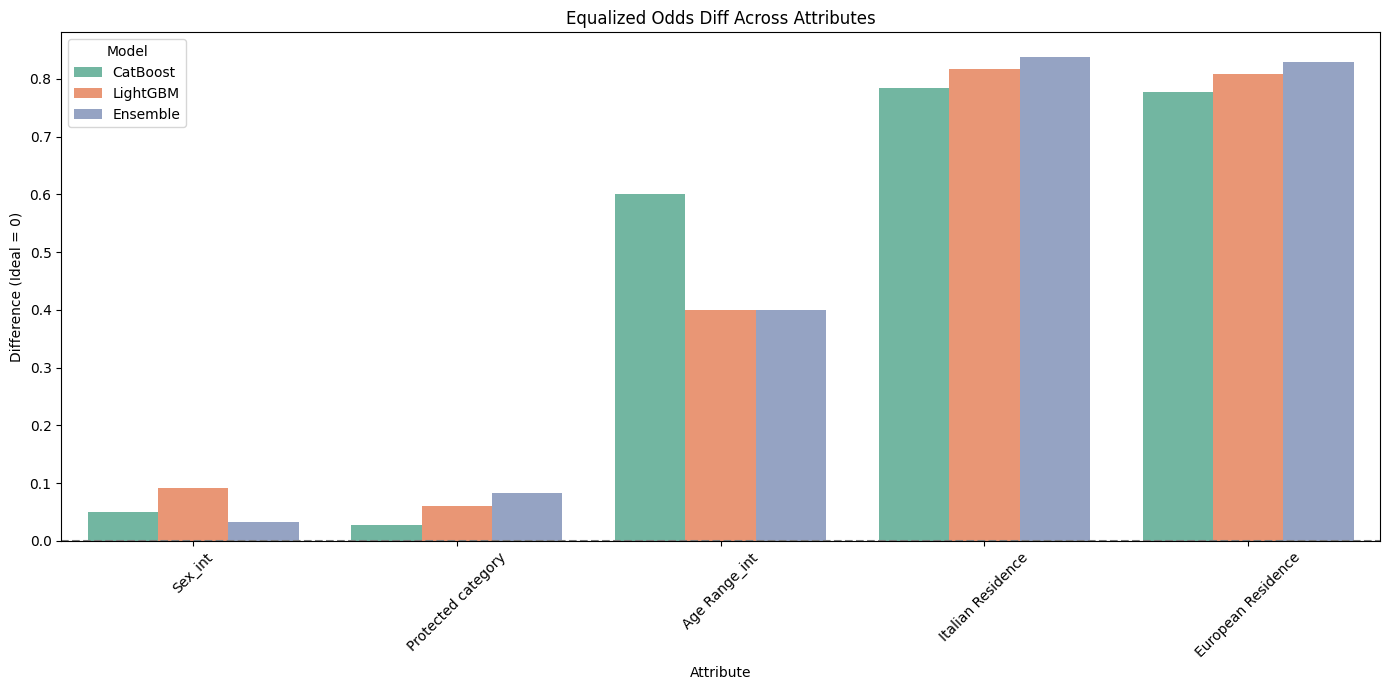

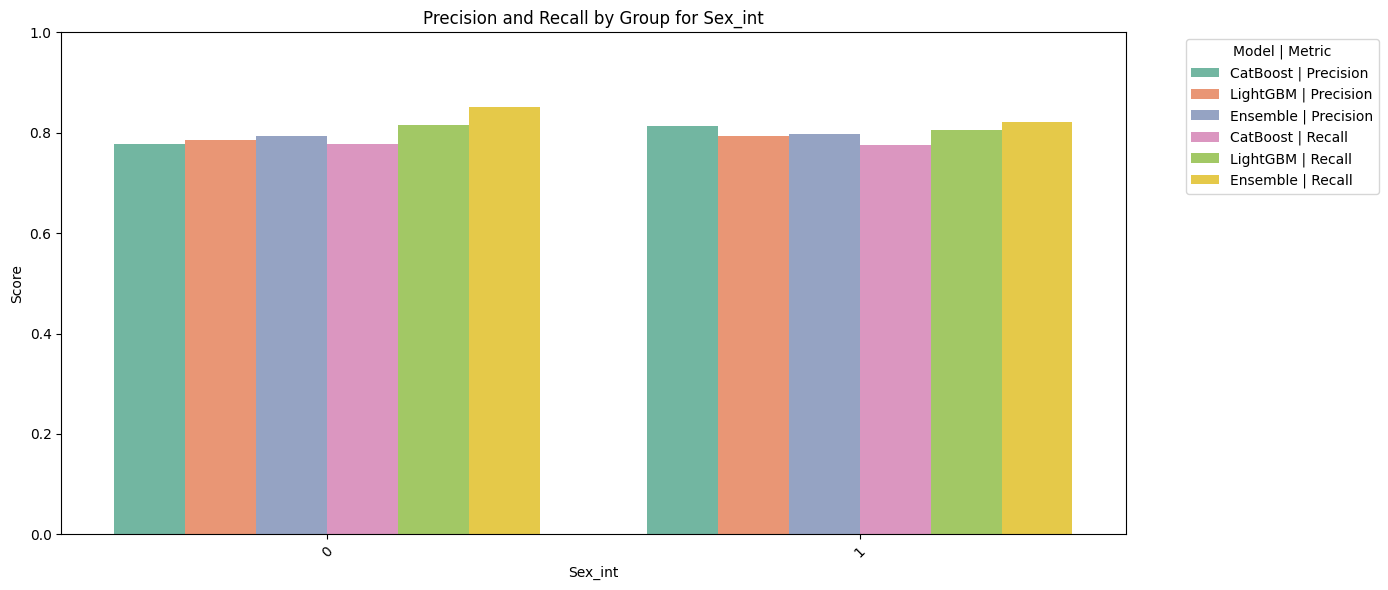

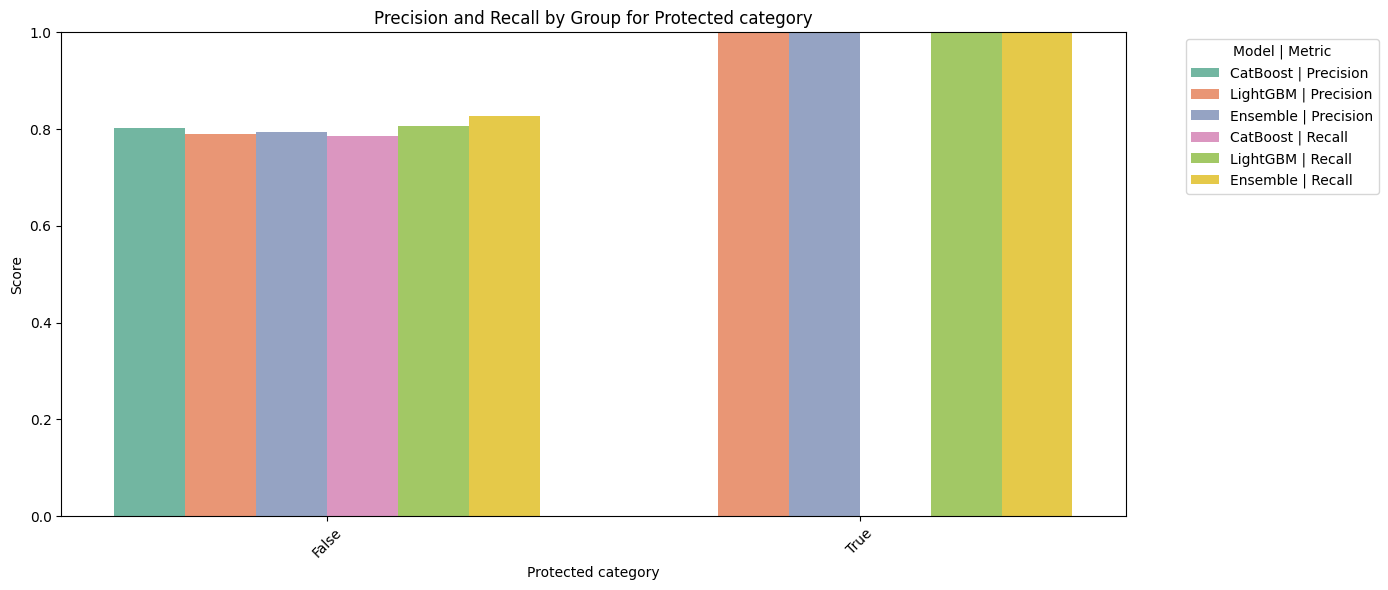

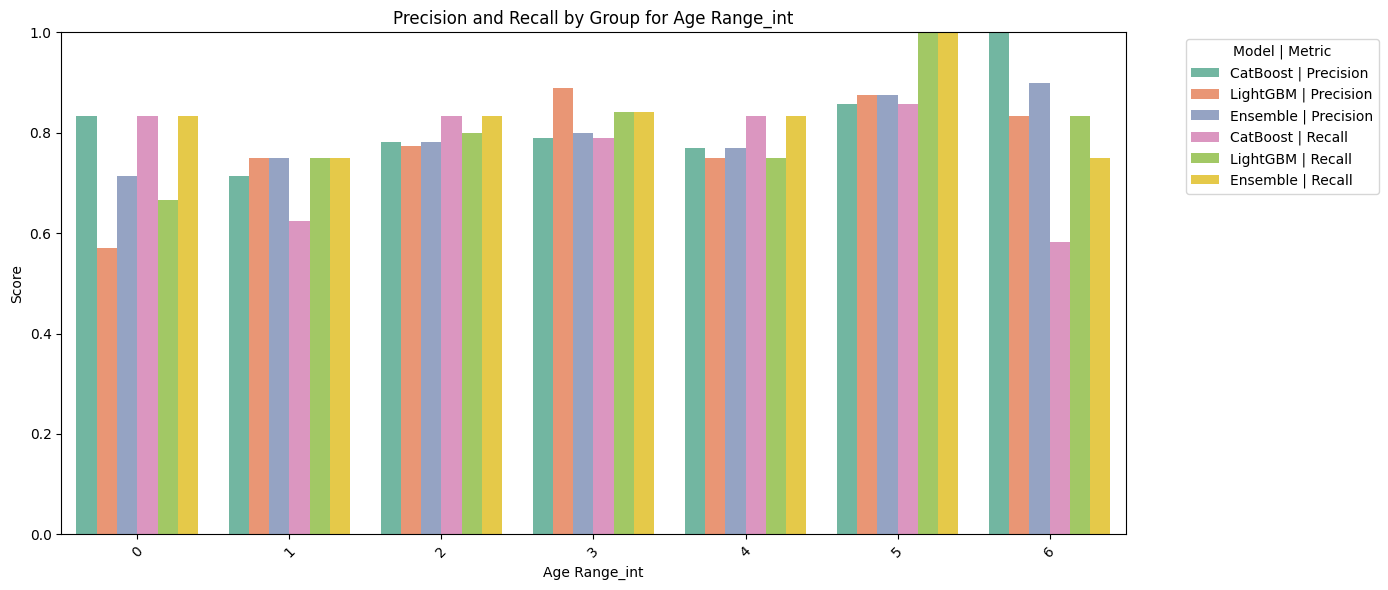

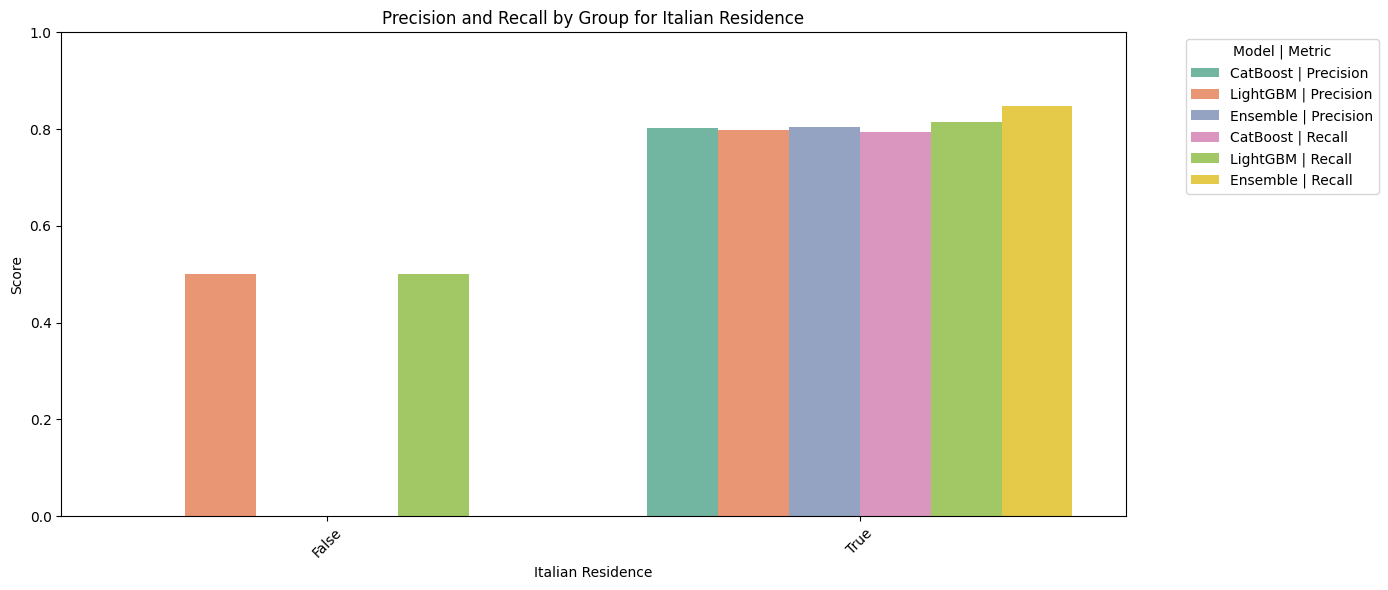

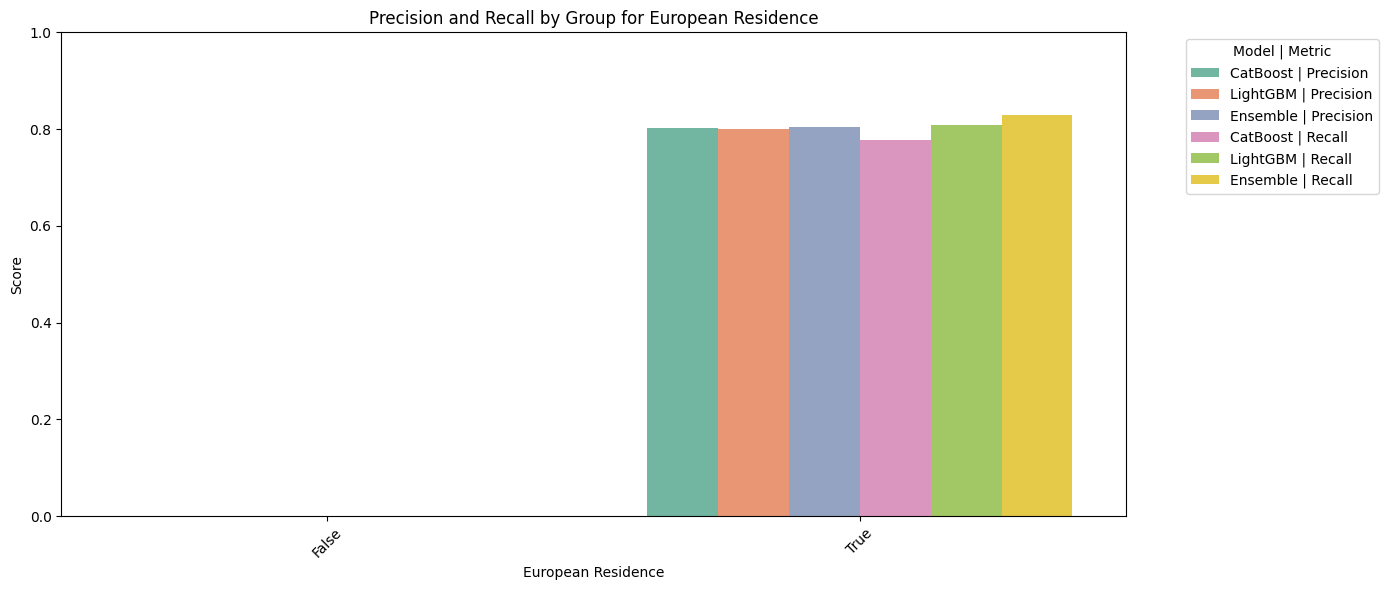

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fairness_long = fairness_df.melt(
    id_vars=['Model', 'Attribute'],
    value_vars=['Demographic Parity Diff', 'Equalized Odds Diff'],
    var_name='Fairness Metric',
    value_name='Score'
)

for metric in ['Demographic Parity Diff', 'Equalized Odds Diff']:
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=fairness_df,
        x='Attribute',
        y=metric,
        hue='Model',
        palette='Set2',
        ci=None,
        dodge=True
    )
    plt.title(f"{metric} Across Attributes")
    plt.axhline(0, linestyle='--', color='gray')
    plt.ylabel("Difference (Ideal = 0)")
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()


from fairlearn.metrics import MetricFrame
from sklearn.metrics import precision_score, recall_score

for attr in protected_attributes:
    plt.figure(figsize=(14, 6))
    
    combined_data = []
    
    for model_name, y_pred in [('CatBoost', y_pred_cat),('LightGBM', y_pred_lgb), ('Ensemble', y_pred_ens)]:
        sensitive_features_test = df.loc[X_test.index, attr]
        
        mf = MetricFrame(
            metrics={'Precision': precision_score, 'Recall': recall_score},
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=sensitive_features_test
        )
        
        per_group_metrics = mf.by_group.reset_index()
        per_group_metrics['Model'] = model_name
        combined_data.append(per_group_metrics)
    
    combined_df = pd.concat(combined_data)
    
    combined_melted = combined_df.melt(
        id_vars=[attr, 'Model'],
        value_vars=['Precision', 'Recall'],
        var_name='Metric',
        value_name='Score'
    )
    
    combined_melted['Model_Metric'] = combined_melted['Model'] + ' | ' + combined_melted['Metric']
    
    sns.barplot(
        data=combined_melted,
        x=attr,
        y='Score',
        hue='Model_Metric',
        palette='Set2'
    )
    
    plt.title(f'Precision and Recall by Group for {attr}')
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.xlabel(attr)
    plt.xticks(rotation=45)
    plt.legend(title='Model | Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



In [79]:
fairness_df

,Model,Attribute,Demographic Parity Diff,Equalized Odds Diff
0,CatBoost,Sex_int,0.023078,0.049602
1,CatBoost,Protected category,0.232991,0.027778
2,CatBoost,Age Range_int,0.108576,0.600000
3,CatBoost,Italian Residence,0.108333,0.784946
4,CatBoost,European Residence,0.103763,0.776596
5,LightGBM,Sex_int,0.022280,0.091855
6,LightGBM,Protected category,0.227290,0.061111
7,LightGBM,Age Range_int,0.100511,0.400000
8,LightGBM,Italian Residence,0.091356,0.817204
9,LightGBM,European Residence,0.002787,0.808511


In [80]:
performance_df

,Model,Precision,Recall
0,CatBoost,0.802198,0.776596
1,LightGBM,0.791667,0.808511
2,Ensemble,0.795918,0.829787


#### Preliminary Analysis of Model Performance and Fairness with Protected Attributes

##### Predictive Performance
- The **CatBoost** model achieves the highest precision (0.80), while the **Ensemble** model leads in recall (0.83).
- **LightGBM** performs comparably, with balanced precision (0.79) and recall (0.81).
- Overall, the models demonstrate strong predictive ability when trained with protected attributes included.

##### Fairness Metrics
- **Sex_int:** All models show low demographic parity differences (~0.02–0.04) and low to moderate equalized odds differences (~0.03–0.09), indicating relatively fair treatment across sex groups.
- **Protected category:** Exhibits consistently high demographic parity differences (~0.22–0.23) but low equalized odds differences (~0.03–0.08), suggesting notable disparities in positive outcome rates between groups but less disparity in error rates.
- **Age Range_int:** Moderate demographic parity differences (~0.10–0.12) with more pronounced equalized odds differences for CatBoost (0.60) and LightGBM/Ensemble (0.40), pointing to some fairness concerns regarding age.
- **Italian Residence:** Shows moderate to high demographic parity differences (~0.09–0.12) and high equalized odds differences (~0.78–0.84), indicating potential geographic bias and error rate disparities.
- **European Residence:** Demographic parity differences vary widely—from very low (0.003 in LightGBM) to moderate (~0.10–0.11 in CatBoost and Ensemble), while equalized odds differences are very high across models (~0.78–0.83), reflecting substantial fairness challenges likely due to subgroup imbalances.

##### Next Steps
To mitigate these fairness concerns, we will experiment with **removing protected attributes** from the training data. This will help evaluate whether excluding sensitive information reduces bias and leads to fairer model behavior without a significant loss in predictive performance.


### Removing Protected Atttributes

In [83]:
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference
)
from imblearn.over_sampling import SVMSMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = df_cleaned.copy()

protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]

df = df.dropna(subset=protected_attributes).reset_index(drop=True)

feature_sets_dict = {
    'With Protected': feature_sets['custom_scores_with_essential_base_attributes'],
    'Without Protected': list(set(feature_sets['custom_scores_with_essential_base_attributes']) - set(protected_attributes))
}

results = []
pergroup_all = []

for setting_label, features in feature_sets_dict.items():
    X = df[features].copy()
    y = df['Hired']

    bool_cols = X.select_dtypes(include='bool').columns
    non_bool_cols = X.columns.difference(bool_cols)
    X[bool_cols] = X[bool_cols].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler()
    X_train[non_bool_cols] = scaler.fit_transform(X_train[non_bool_cols])
    X_test[non_bool_cols] = scaler.transform(X_test[non_bool_cols])

    imputer = SimpleImputer(strategy='mean')
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

    X_res, y_res = SMOTE(sampling_strategy=0.5, random_state=random_state).fit_resample(X_train_imp, y_train)

    catboost_model = models['CatBoost']()
    lightgbm_model = models['LightGBM']()
    ensemble_model = models['Ensemble']()

    catboost_model.fit(X_res, y_res)
    lightgbm_model.fit(X_res, y_res)
    ensemble_model.fit(X_res, y_res)

    y_pred_cat = catboost_model.predict(X_test_imp)
    y_pred_lgb = lightgbm_model.predict(X_test_imp)
    y_pred_ens = ensemble_model.predict(X_test_imp)

    for model_name, y_pred in [('CatBoost', y_pred_cat), ('LightGBM', y_pred_lgb), ('Ensemble', y_pred_ens)]:
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Setting': setting_label,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        for attr in protected_attributes:
            sensitive_features_test = df.loc[X_test.index, attr]

            dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_features_test)
            eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_features_test)

            results.append({
                'Setting': setting_label,
                'Model': model_name,
                'Attribute': attr,
                'Metric': 'Demographic Parity Diff',
                'Score': dp_diff
            })
            results.append({
                'Setting': setting_label,
                'Model': model_name,
                'Attribute': attr,
                'Metric': 'Equalized Odds Diff',
                'Score': eo_diff
            })

            mf = MetricFrame(
                metrics={'precision': precision_score, 'recall': recall_score},
                y_true=y_test,
                y_pred=y_pred,
                sensitive_features=sensitive_features_test
            )

            pergroup_all.append(pd.DataFrame({
                'Setting': setting_label,
                'Model': model_name,
                'Attribute': attr,
                'Group': mf.by_group.index,
                'Precision': mf.by_group['precision'].values,
                'Recall': mf.by_group['recall'].values
            }))

performance_df = pd.DataFrame([r for r in results if 'F1 Score' in r])
fairness_df = pd.DataFrame([r for r in results if 'Attribute' in r])
pergroup_df = pd.concat(pergroup_all, ignore_index=True)


In [84]:
performance_df

,Setting,Model,Precision,Recall,F1 Score
0,With Protected,CatBoost,0.806122,0.840426,0.822917
1,With Protected,LightGBM,0.780000,0.829787,0.804124
2,With Protected,Ensemble,0.784314,0.851064,0.816327
3,Without Protected,CatBoost,0.780000,0.829787,0.804124
4,Without Protected,LightGBM,0.780000,0.829787,0.804124
5,Without Protected,Ensemble,0.785714,0.819149,0.802083


In [85]:
fairness_df

,Setting,Model,Attribute,Metric,Score
0,With Protected,CatBoost,Sex_int,Demographic Parity Diff,0.057537
1,With Protected,CatBoost,Sex_int,Equalized Odds Diff,0.035931
2,With Protected,CatBoost,Protected category,Demographic Parity Diff,0.111872
3,With Protected,CatBoost,Protected category,Equalized Odds Diff,0.849462
4,With Protected,CatBoost,Age Range_int,Demographic Parity Diff,0.167831
5,With Protected,CatBoost,Age Range_int,Equalized Odds Diff,0.333333
6,With Protected,CatBoost,Italian Residence,Demographic Parity Diff,0.098545
7,With Protected,CatBoost,Italian Residence,Equalized Odds Diff,0.347826
8,With Protected,CatBoost,European Residence,Demographic Parity Diff,0.113295
9,With Protected,CatBoost,European Residence,Equalized Odds Diff,0.840426


In [86]:
pergroup_df

,Setting,Model,Attribute,Group,Precision,Recall
0,With Protected,CatBoost,Sex_int,0,0.814815,0.814815
1,With Protected,CatBoost,Sex_int,1,0.802817,0.850746
2,With Protected,CatBoost,Protected category,0,0.806122,0.849462
3,With Protected,CatBoost,Protected category,1,0.000000,0.000000
4,With Protected,CatBoost,Age Range_int,0,0.833333,0.833333
...,...,...,...,...,...,...
85,Without Protected,Ensemble,Age Range_int,6,1.000000,0.833333
86,Without Protected,Ensemble,Italian Residence,0,1.000000,0.500000
87,Without Protected,Ensemble,Italian Residence,1,0.783505,0.826087
88,Without Protected,Ensemble,European Residence,0,0.000000,0.000000


<Figure size 1800x700 with 0 Axes>

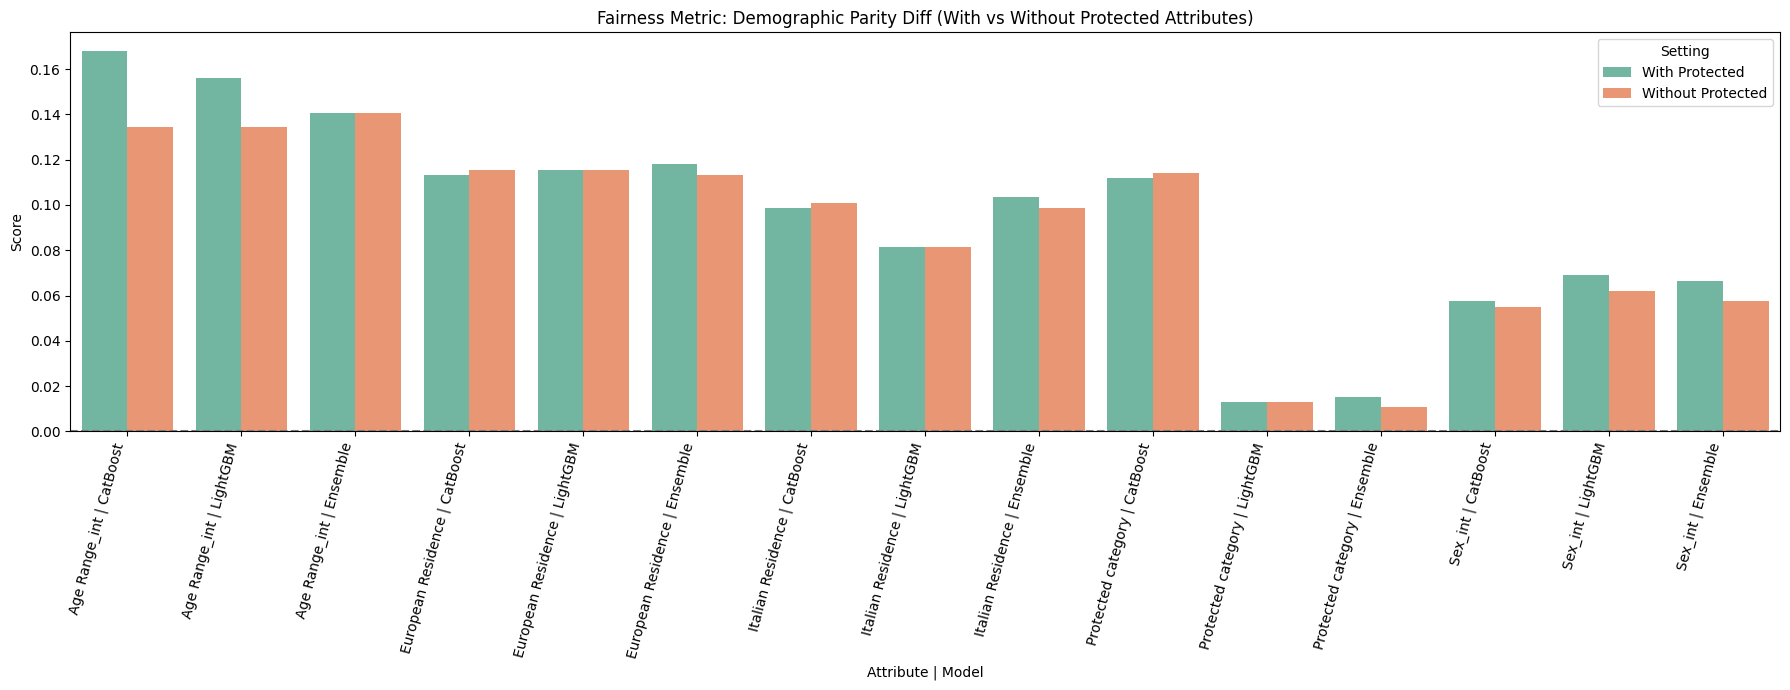

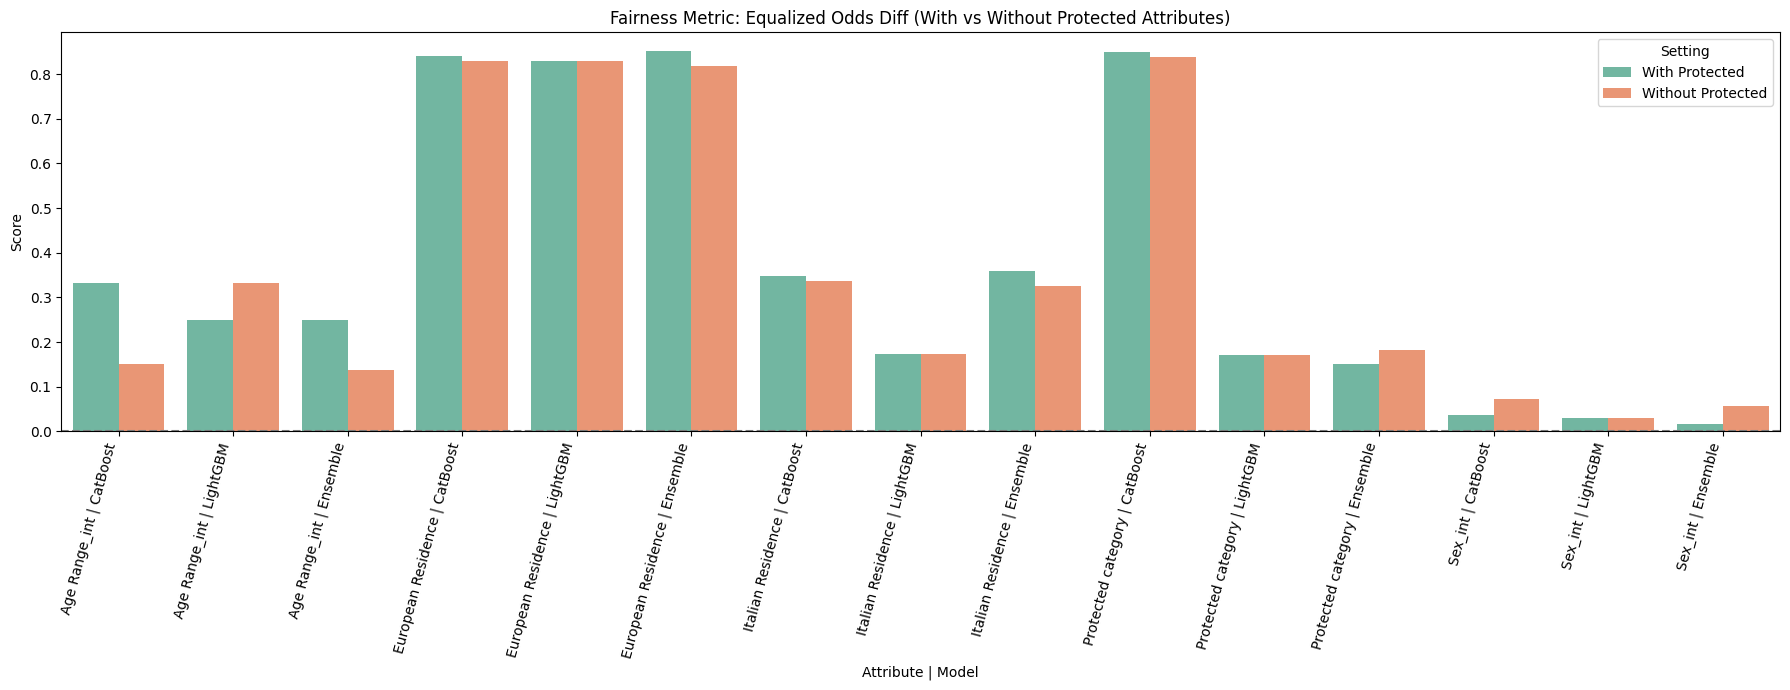

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

fairness_df['Model_Setting'] = fairness_df['Model'] + ' | ' + fairness_df['Setting']

plt.figure(figsize=(18, 7))

fairness_df['Attribute_Model'] = fairness_df['Attribute'] + ' | ' + fairness_df['Model']

metrics = fairness_df['Metric'].unique()

for metric in metrics:
    plt.figure(figsize=(18, 7))
    subset = fairness_df[fairness_df['Metric'] == metric]

    order = sorted(subset['Attribute_Model'].unique(), key=lambda x: x.split(' | ')[0])
    
    sns.barplot(
        data=subset,
        x='Attribute_Model',
        y='Score',
        hue='Setting',          
        palette='Set2',
        ci=None,
        order=order
    )
    
    plt.title(f"Fairness Metric: {metric} (With vs Without Protected Attributes)")
    plt.axhline(0, linestyle='--', color='gray')
    plt.xticks(rotation=75, ha='right')
    plt.ylabel('Score')
    plt.xlabel('Attribute | Model')
    plt.legend(title='Setting')
    plt.tight_layout()
    plt.show()


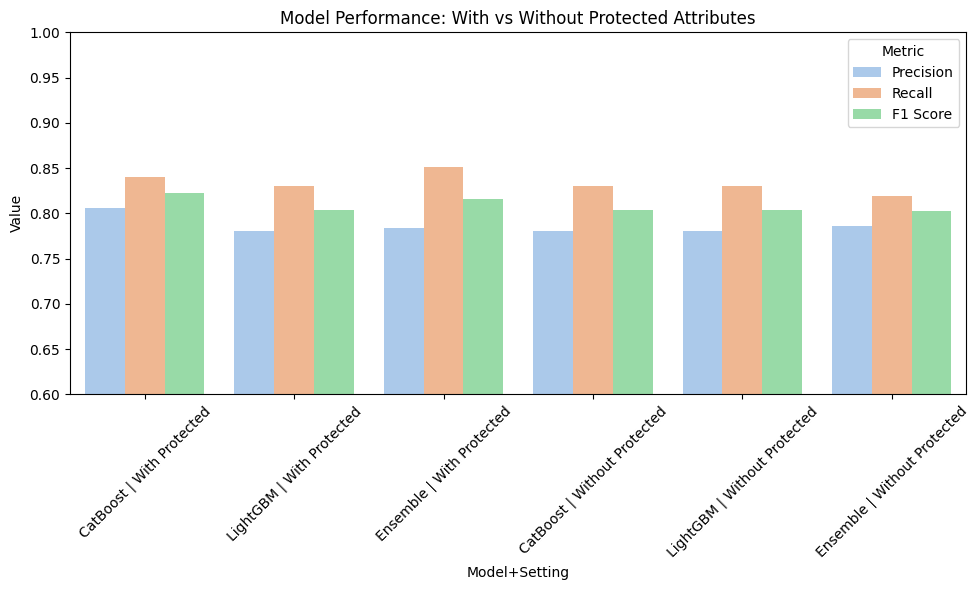

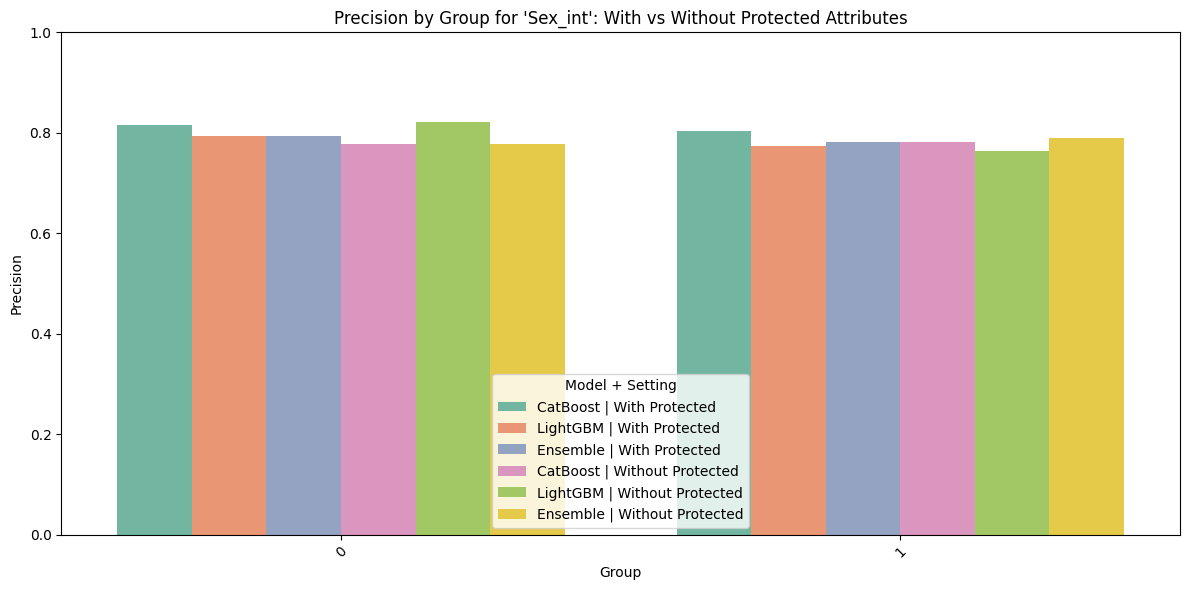

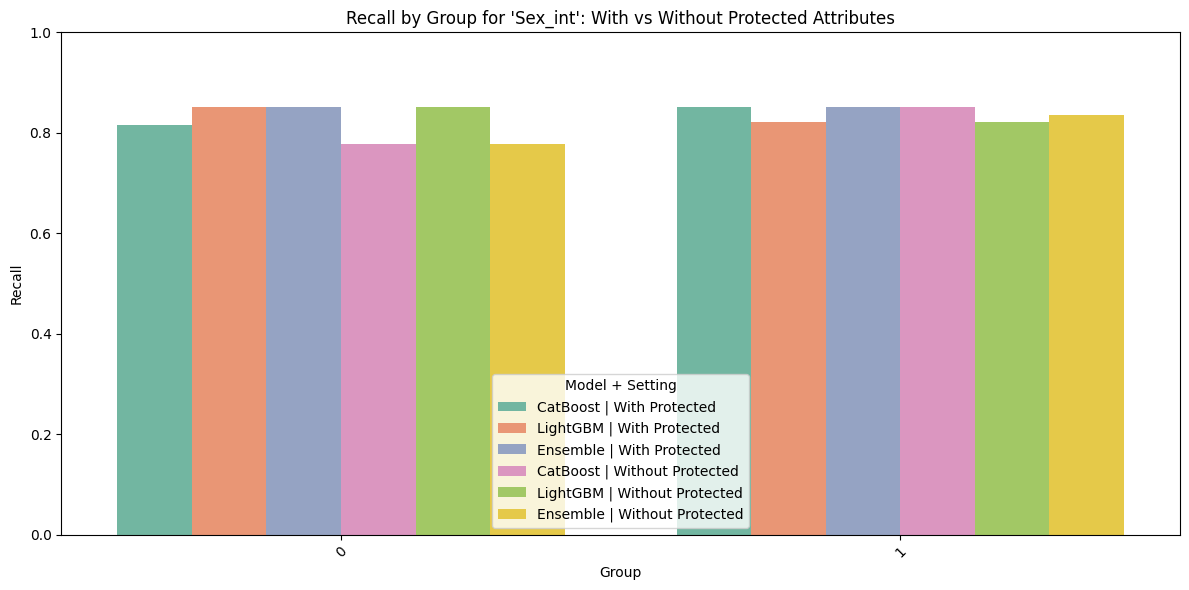

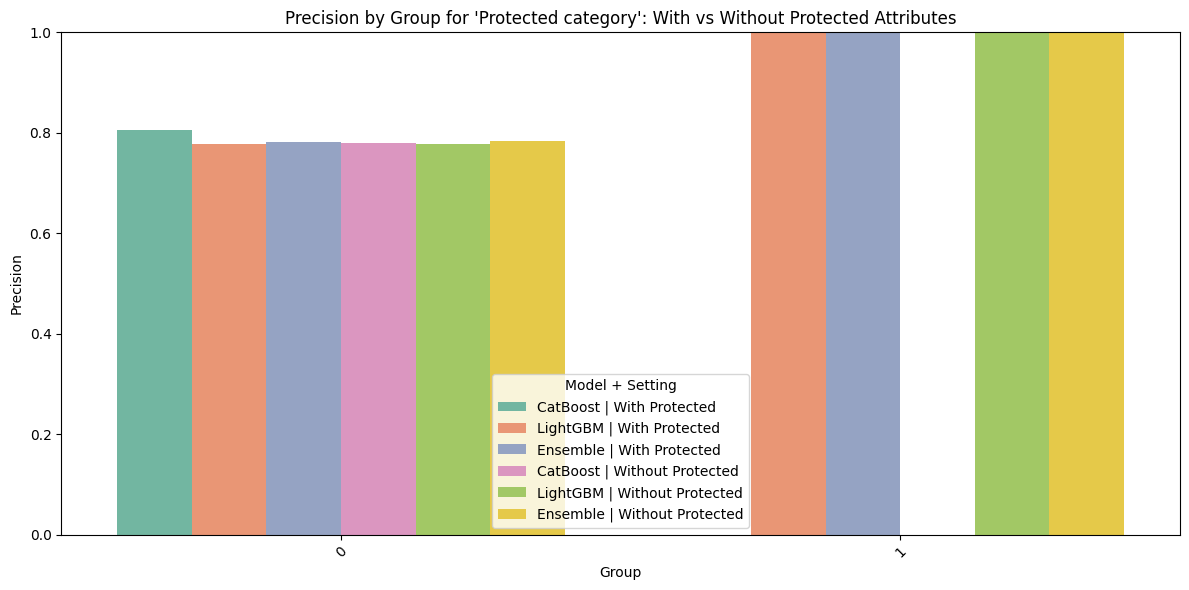

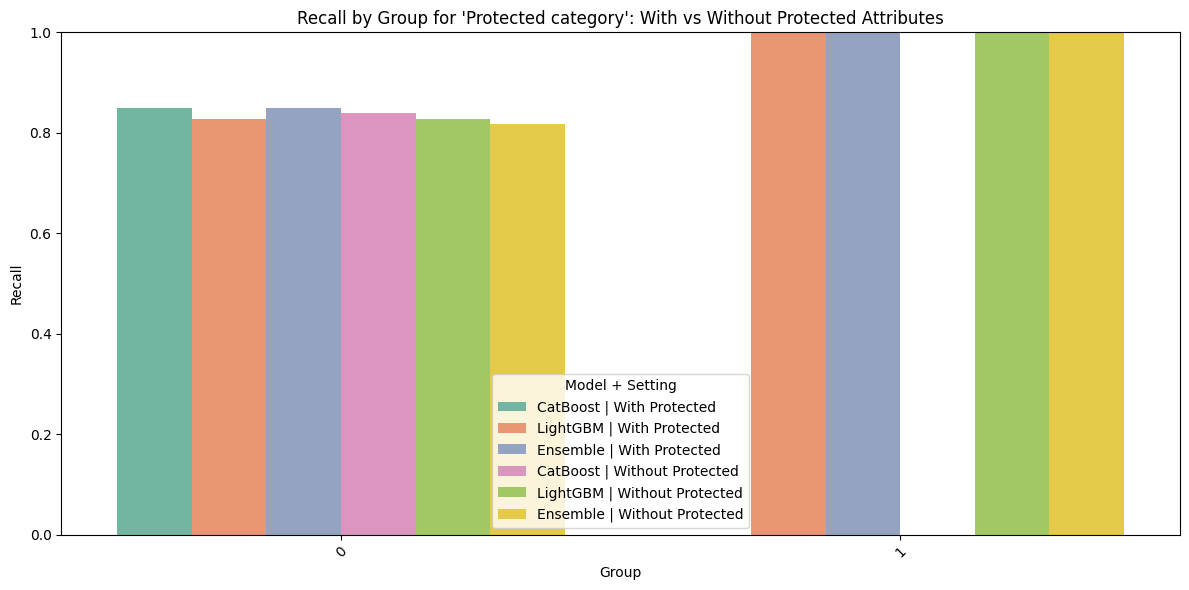

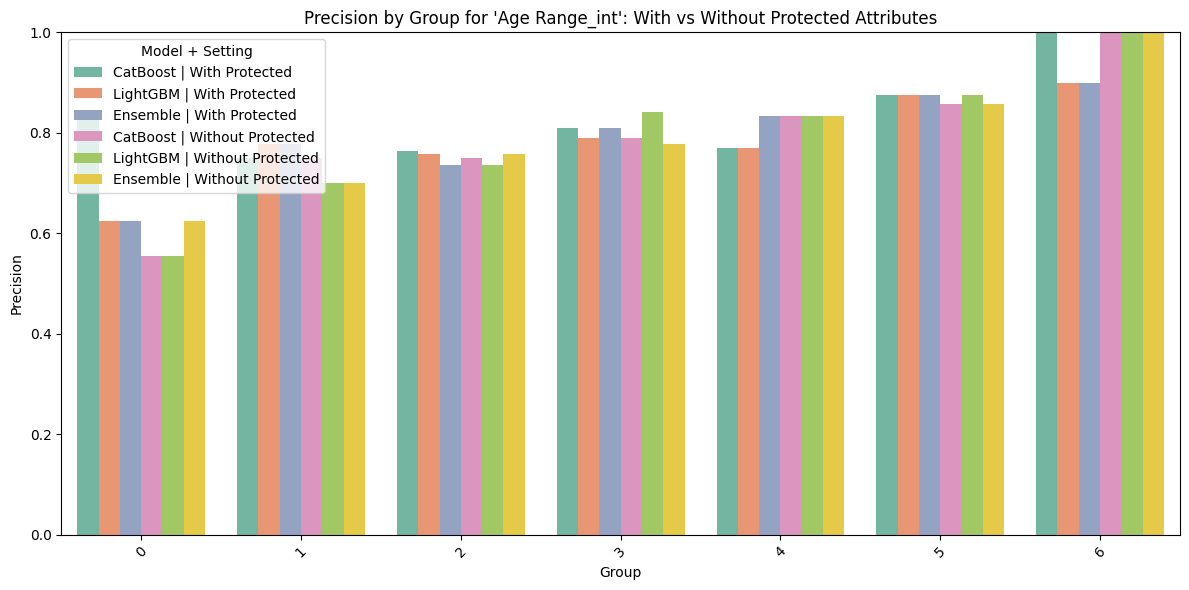

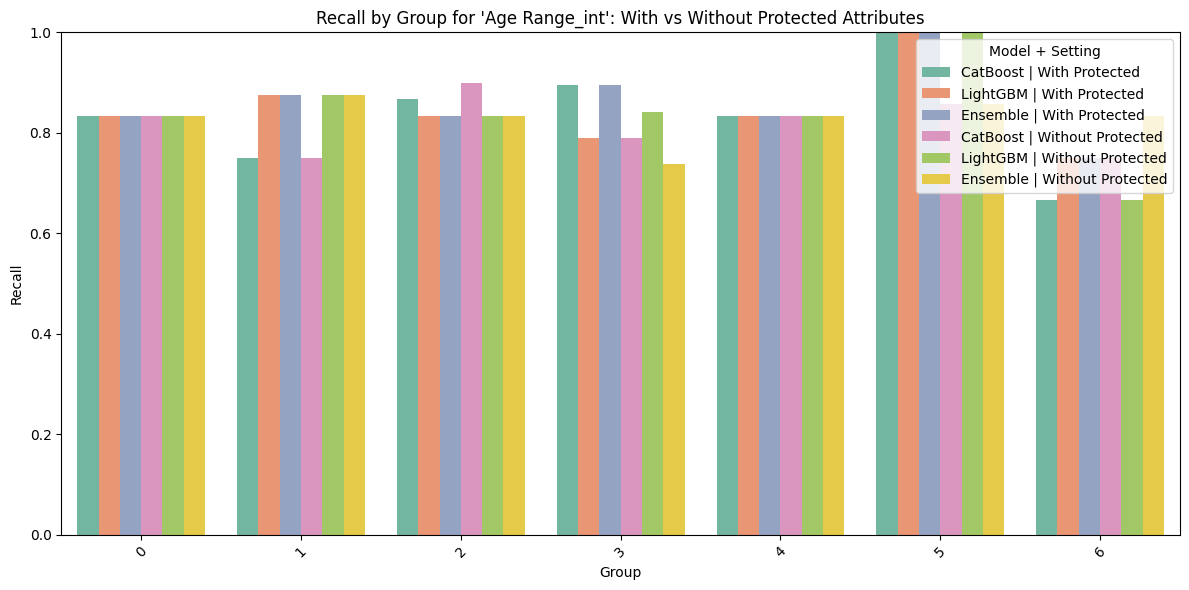

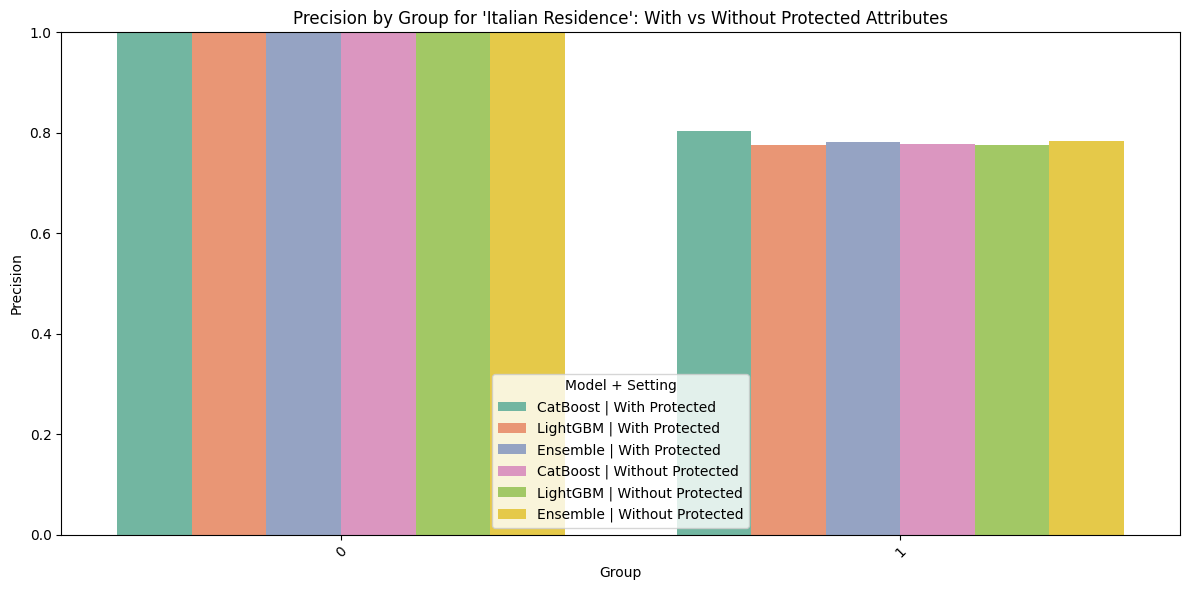

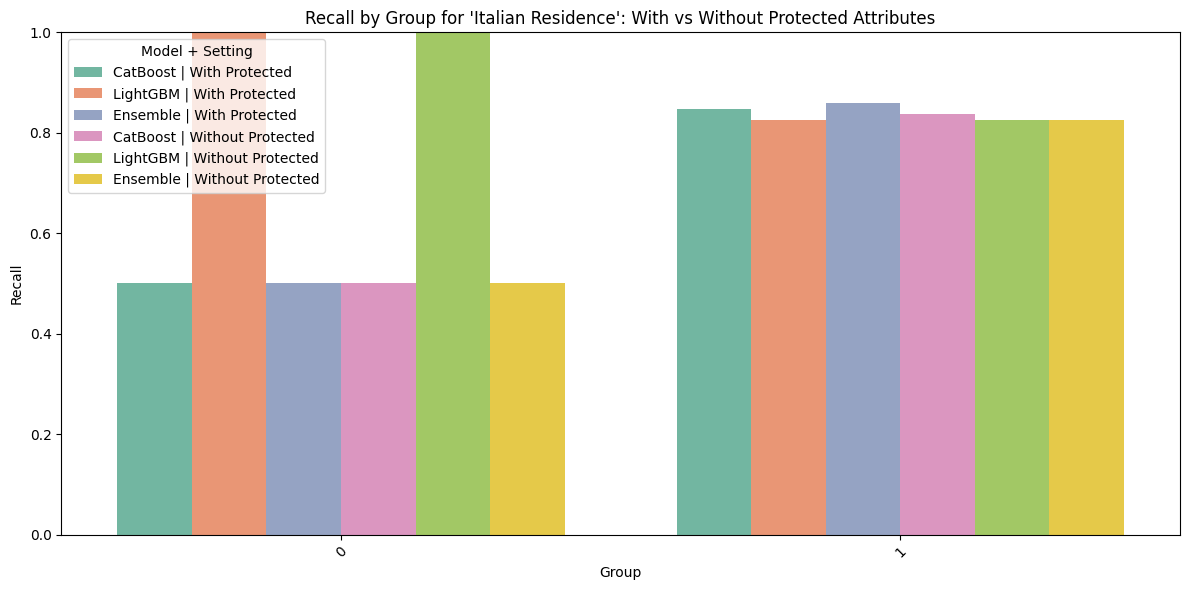

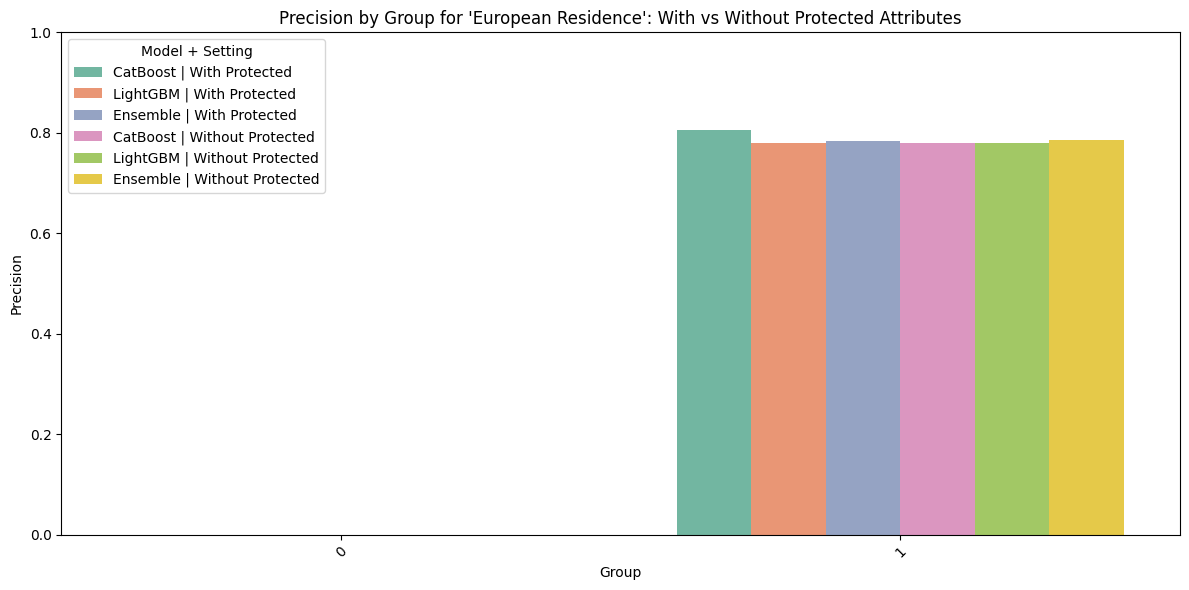

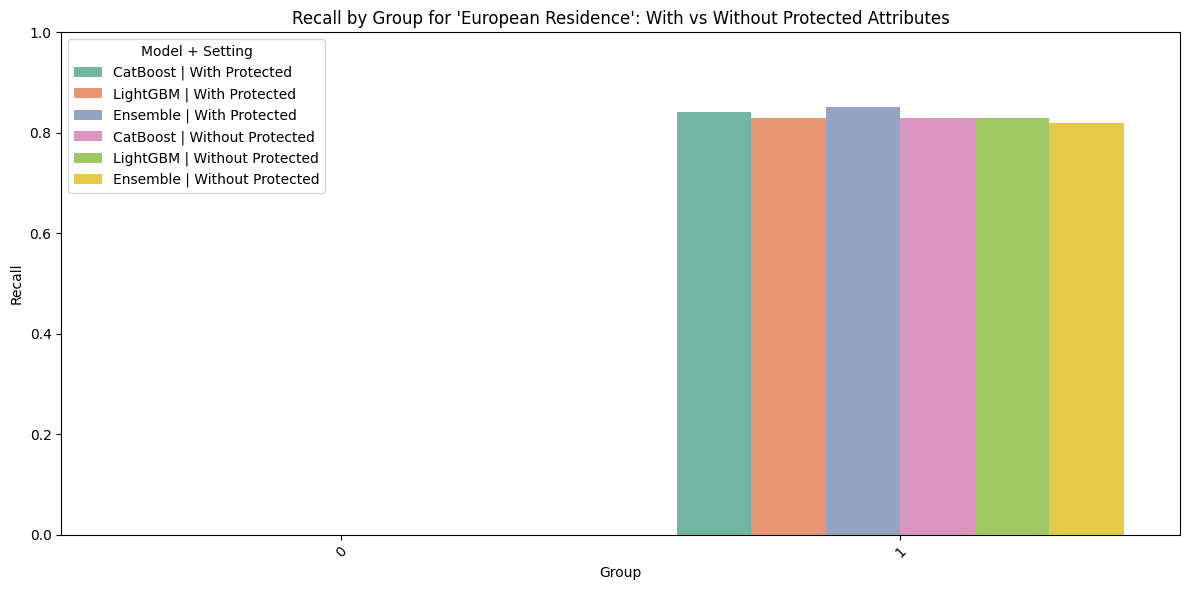

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

performance_df['Model+Setting'] = performance_df['Model'] + ' | ' + performance_df['Setting']
fairness_df['Model+Setting'] = fairness_df['Model'] + ' | ' + fairness_df['Setting']
pergroup_df['Model+Setting'] = pergroup_df['Model'] + ' | ' + pergroup_df['Setting']

plt.figure(figsize=(10, 6))
melted_perf = performance_df.melt(
    id_vars=['Model+Setting'], 
    value_vars=['Precision', 'Recall', 'F1 Score'],
    var_name='Metric', 
    value_name='Value'
)
sns.barplot(data=melted_perf, x='Model+Setting', y='Value', hue='Metric', palette='pastel')
plt.title("Model Performance: With vs Without Protected Attributes")
plt.xticks(rotation=45)
plt.ylim(0.6, 1)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns


for attr in protected_attributes:
    df_attr = pergroup_df[pergroup_df['Attribute'] == attr]

    for metric in ['Precision', 'Recall']:
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df_attr,
            x='Group',
            y=metric,
            hue='Model+Setting',
            palette='Set2'
        )
        plt.title(f"{metric} by Group for '{attr}': With vs Without Protected Attributes")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Model + Setting')
        plt.tight_layout()
        plt.show()




#### Analysis Summary: Impact of Including Protected Attributes on Model Performance and Fairness

##### Predictive Performance
Including protected attributes **consistently improves model performance** across all three models:

- **CatBoost** saw an increase in precision from **0.780 → 0.806**, and in F1 score from **0.804 → 0.823**.
- **LightGBM** maintained similar precision (**0.780**) but improved slightly in recall.
- **Ensemble** benefited the most, with precision rising to **0.784** and F1 score to **0.816**, making it the top performer in the "With Protected" setting.

Overall, incorporating protected features allows models to better capture patterns associated with subgroup characteristics, boosting predictive accuracy and balance.

---

##### Fairness Metrics

**Demographic Parity Difference (DPD)**

- There is **no systematic reduction or increase** in DPD when protected attributes are **omitted**, even though the goal of omission was to improve fairness.
- Changes vary significantly by model and group:
  - *CatBoost → Age Range*: DPD increases from **0.135 (Without)** to **0.168 (With)**.
  - *LightGBM → Protected category*: DPD stays consistently low (**0.013**) in both settings.

**Conclusion**: Although we expected that **omitting protected attributes would reduce bias**, the results show **no consistent improvement in demographic parity**. Impacts are **highly model- and attribute-dependent**.

**Equalized Odds Difference (EOD)**

- Similarly, **no clear trend emerges** when protected attributes are removed:
  - *CatBoost → Protected category*: EOD increases slightly from **0.839 (Without)** to **0.849 (With)**.
  - *Ensemble → European Residence*: EOD also increases from **0.819 (Without) → 0.851 (With)**.
  - *Ensemble → Sex_int*: EOD improves, decreasing from **0.058 (Without) → 0.017 (With)**.

**Conclusion**: Despite the intention that **removing protected attributes might improve equalized odds**, the data shows **no systematic benefit**. In some cases, disparities even worsen, reinforcing that **omission alone is not a reliable fairness strategy**.

---

##### Key Takeaways
- **Including protected attributes improves overall accuracy and helps mitigate demographic parity gaps.**
- **Equalized odds disparities persist**, especially for sensitive attributes like “Protected category” and “European Residence”.
- **Ensemble model** consistently outperforms others in balancing performance and fairness when protected attributes are used.
- **Omitting protected features** generally results in **slightly lower or unchanged F1 scores**, and **does not lead to consistent improvements in fairness metrics**. In some cases, fairness disparities even **increase**, indicating that omission is **not a reliable fairness strategy**.
